<a id='Table of Contents'></a><h1>Table of Contents</h1>

- <a href='#introduction'>Introduction</a> 
- <a href='#imports'>Import and install required libraries</a>  
- <a href='#set_fitting'>Setting of fitting</a>  
- <a href='#run_fit'>Running the fit</a>  
- <a href='#results'>Showing the results</a> 

(<a href='#Table of Contents'>Top</a>)<a id='introduction'></a><h2>Introduction</h2>

<div class="alert alert-block alert-info">
The objective of this notebook is to show how to use the `water_teixeira` model .
</div>

The data are two sets of water data measured at IN5 (ILL) using two different wavelengths.

**Reference:** J. Qvist, H. Schober and B. Halle, J. Chem. Phys. 134, 144508 (2011)

(<a href='#Table of Contents'>Top</a>)<a id='imports'></a><h2> Import python modules for plotting, fitting... </h2>

In [1]:
# Imported required libraries
from __future__ import print_function
import sys
import os

import ipywidgets

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# install bumps (if not already installed)
import pkgutil
if not pkgutil.find_loader("bumps"):
    !{sys.executable} -m pip install bumps

 (<a href='#Table of Contents'>Top</a>)<a id='set_fitting'></a><h2>Setting of fitting </h2>
<h3> load data, prepare data, create fitting model and set initial guesses </h3>

These settings are saved in a Python script, which will be used by Bumps to run the fit.

In [3]:
# Name of Python script containing the model
model_file = "model_fit_water2.py"

In [4]:
%%writefile $model_file
import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
from bumps.names import *

path_to_data = './data/'

import h5py
import QENSmodels
import qens_models # to be removed
import numpy as np
from scipy.integrate import simps
from bumps.names import *

# Data
# Wavelength 5 Angstrom
f = h5py.File(path_to_data + 'H2O_293K_5A.hdf', 'r')
hw_5A = f['entry1']['data1']['X'][:]
q_5A = f['entry1']['data1']['Y'][:]
sqw_5A = np.transpose(f['entry1']['data1']['DATA'][:])
err_5A = np.transpose(f['entry1']['data1']['errors'][:])
f.close()

# Wavelength 8 Angstrom
f = h5py.File(path_to_data + 'H2O_293K_8A.hdf', 'r')
hw_8A = f['entry1']['data1']['X'][:]
q_8A = f['entry1']['data1']['Y'][:]
sqw_8A = np.transpose(f['entry1']['data1']['DATA'][:])
err_8A = np.transpose(f['entry1']['data1']['errors'][:])
f.close()

# Resolution
# Wavelength 5 Angstrom
f = h5py.File(path_to_data + 'V_273K_5A.hdf', 'r')
res_5A = np.transpose(f['entry1']['data1']['DATA'][:])
f.close()

# Wavelength 8 Angstrom
f = h5py.File(path_to_data + 'V_273K_8A.hdf', 'r')
res_8A = np.transpose(f['entry1']['data1']['DATA'][:])
f.close()

# Force resolution function to have unit area
# 5 Angstrom
for i in range(len(q_5A)):
    area = simps(res_5A[:,i], hw_5A)
    res_5A[:,i] /= area 
    
# 8 Angstrom
for i in range(len(q_8A)):
    area = simps(res_8A[:,i], hw_8A)
    res_8A[:,i] /= area
    
# Fit range -1 to +1 meV
idx_5A = np.where(np.logical_and(hw_5A > -1.0, hw_5A < 1.0))
idx_8A = np.where(np.logical_and(hw_8A > -1.0, hw_8A < 1.0))

def model_convol(x, q, scale=1, center=0, D=1, resTime=1, radius=1, DR=1, resolution=None):
    model = QENSmodels.sqwWaterTeixeira(x, q, scale, center, D, resTime, radius, DR)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

# Fit
M = []

# First dataset: wavelength=5 Angstrom 
for i in range(len(q_5A)):

    x = hw_5A[idx_5A]
    data = sqw_5A[idx_5A, i]
    error = err_5A[idx_5A, i]
    resol = res_5A[idx_5A,i]
        
    # Select only valid data (error = -1 for Q, w points not accessible)
    valid = np.where(error > 0.0)
    x = x[valid[1]]
    data = data[valid]
    error = error[valid]
    resol = resol[valid]

    # Teixeira model        
    Mq = Curve(model_convol, x, data, error, q=q_5A[i],
               scale=10, center=0.0, D=0.13, resTime=0.1, radius=1.0, 
               DR=0.3, resolution=resol)
    
    # Fitted parameters    
    Mq.scale.range(0, 1e2)
    Mq.center.range(-0.1,0.1)
    Mq.D.range(0.05, 0.25)
    Mq.resTime.range(0,1)
    Mq.radius.range(0.9,1.1)
    Mq.DR.range(0,1)
    
    # Q-independent parameters
    if i == 0:
        QD = Mq.D
        QT = Mq.resTime
        QR = Mq.radius
        QDR = Mq.DR
    else:
        Mq.D = QD
        Mq.resTime = QT
        Mq.radius = QR
        Mq.DR = QDR
   
    M.append(Mq)
    
# Second dataset: wavelength=8 Angstrom
for i in range(len(q_8A)):

    x = hw_8A[idx_8A]
    data = sqw_8A[idx_8A, i]
    error = err_8A[idx_8A, i]
    resol = res_8A[idx_8A,i]
        
    # Select only valid data (error = -1 for Q, w points not accessible)
    valid = np.where(error > 0.0)
    x = x[valid[1]]
    data = data[valid]
    error = error[valid]
    resol = resol[valid]
    
    Mq = Curve(model_convol, x, data, error, q=q_8A[i],
               scale=10, center=0.0, D=0.13, resTime=0.1, radius=1.0, 
               DR=0.3, resolution=resol)

    # Fitted parameters    
    Mq.scale.range(0, 1e2)
    Mq.center.range(-0.1,0.1)
    Mq.D.range(0.05, 0.25)
    Mq.resTime.range(0,1)
    Mq.radius.range(0.9,1.1)
    Mq.DR.range(0,1)
    
    # Q-independent parameters set with 5A data
    Mq.D = QD
    Mq.resTime = QT
    Mq.radius = QR
    Mq.DR = QDR
       
    M.append(Mq) 
    
problem = FitProblem(M)

Writing model_fit_water2.py


<h3> Choice of minimizer for bumps </h3>

In [5]:
w_choice_minimizer = ipywidgets.widgets.Dropdown(
    options={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"},
    value="lm",
    description='Minimizer:',)

display(w_choice_minimizer)

Dropdown(description=u'Minimizer:', index=4, options={'Quasi-Newton BFGS': 'newton', 'Random Lines (experimental)': 'rl', 'Parallel Tempering (experimental)': 'pt', 'Particle Swarm (experimental)': 'ps', 'Levenberg-Marquardt': 'lm', 'Differential Evolution': 'de', 'Nelder-Mead Simplex': 'amoeba', 'DREAM': 'dream'}, value='lm')

<h3> Setting for running bumps </h3>

In [6]:
# CHOICE OF MINIMIZER
minimiser = w_choice_minimizer.value

# NUMBER OF STEPS WHEN RUNNING THE FIT
steps = 100

# output folder to save thre results
output_folder = 'QENS'

(<a href='#Table of Contents'>Top</a>)<a id='run_fit'></a><h2>Running the fit</h2>

Run the fit using the *minimizer* defined above with a number of *steps* also specified above
The subfolder *output_folder* contains different results: plots and 
refined parameters

# /Users/celinedurniak/anaconda/envs/aseenv/lib/python2.7/site-packages/bumps/cli.py model_fit_water2.py --fit=lm --steps=100 --store=QENS
-- Model 0 
.D = Parameter(0.13, name='D', bounds=(0.05,0.25))
.DR = Parameter(0.3, name='DR', bounds=(0,1))
.center = Parameter(0, name='center', bounds=(-0.1,0.1))
.q = Parameter(0.5, name='q')
.radius = Parameter(1, name='radius', bounds=(0.9,1.1))
.resTime = Parameter(0.1, name='resTime', bounds=(0,1))
.scale = Parameter(10, name='scale', bounds=(0,100))

('eisf2', array([ 0.91939539]))
('qisf2', array([[  0.00000000e+00,   7.92548590e-02,   1.34006566e-03,
          9.64851456e-06,   3.84822053e-08,   9.75183989e-11]]))
[chisq=16926.675(98), nllf=609360]
-- Model 1 
.D = Parameter(0.13, name='D', bounds=(0.05,0.25))
.DR = Parameter(0.3, name='DR', bounds=(0,1))
.center = Parameter(0, name='center', bounds=(-0.1,0.1))
.q = Parameter(0.6, name='q')
.radius = Parameter(1, name='radius', bounds=(0.9,1.1))
.resTime = Parameter(0.1, name='resTime', b

          3.08266764e-04,   4.02947130e-06,   3.33466797e-08]]))
('eisf2', array([ 0.70807342]))
('qisf2', array([[  0.00000000e+00,   2.72107720e-01,   1.92417384e-02,
          5.67829524e-04,   9.19937668e-06,   9.42432489e-08]]))
('eisf2', array([ 0.65640541]))
('qisf2', array([[  0.00000000e+00,   3.15268104e-01,   2.73244185e-02,
          9.82483579e-04,   1.93438956e-05,   2.40503560e-07]]))
('eisf2', array([ 0.60326168]))
('qisf2', array([[  0.00000000e+00,   3.57664322e-01,   3.74217972e-02,
          1.61363784e-03,   3.79914845e-05,   5.63989056e-07]]))
('eisf2', array([ 0.54937533]))
('qisf2', array([[  0.00000000e+00,   3.98328095e-01,   4.96890659e-02,
          2.53582355e-03,   7.04373023e-05,   1.23160655e-06]]))
('eisf2', array([ 0.4954649]))
('qisf2', array([[  0.00000000e+00,   4.36341515e-01,   6.42300878e-02,
          3.83663216e-03,   1.24302782e-04,   2.53053714e-06]]))
('eisf2', array([ 0.44222055]))
('qisf2', array([[  0.00000000e+00,   4.70859068e-01,   8.1

          1.54980008e-04,   1.59504874e-06,   1.04046568e-08]]))
('eisf2', array([ 0.75753214]))
('qisf2', array([[  0.00000000e+00,   2.29178484e-01,   1.29770459e-02,
          3.08266764e-04,   4.02947130e-06,   3.33466797e-08]]))
('eisf2', array([ 0.70807342]))
('qisf2', array([[  0.00000000e+00,   2.72107720e-01,   1.92417384e-02,
          5.67829524e-04,   9.19937668e-06,   9.42432489e-08]]))
('eisf2', array([ 0.65640541]))
('qisf2', array([[  0.00000000e+00,   3.15268104e-01,   2.73244185e-02,
          9.82483579e-04,   1.93438956e-05,   2.40503560e-07]]))
('eisf2', array([ 0.60326168]))
('qisf2', array([[  0.00000000e+00,   3.57664322e-01,   3.74217972e-02,
          1.61363784e-03,   3.79914845e-05,   5.63989056e-07]]))
('eisf2', array([ 0.54937533]))
('qisf2', array([[  0.00000000e+00,   3.98328095e-01,   4.96890659e-02,
          2.53582355e-03,   7.04373023e-05,   1.23160655e-06]]))
('eisf2', array([ 0.4954649]))
('qisf2', array([[  0.00000000e+00,   4.36341515e-01,   6.4

('eisf2', array([ 0.75753214]))
('qisf2', array([[  0.00000000e+00,   2.29178484e-01,   1.29770459e-02,
          3.08266764e-04,   4.02947130e-06,   3.33466797e-08]]))
('eisf2', array([ 0.70807342]))
('qisf2', array([[  0.00000000e+00,   2.72107720e-01,   1.92417384e-02,
          5.67829524e-04,   9.19937668e-06,   9.42432489e-08]]))
('eisf2', array([ 0.65640541]))
('qisf2', array([[  0.00000000e+00,   3.15268104e-01,   2.73244185e-02,
          9.82483579e-04,   1.93438956e-05,   2.40503560e-07]]))
('eisf2', array([ 0.60326168]))
('qisf2', array([[  0.00000000e+00,   3.57664322e-01,   3.74217972e-02,
          1.61363784e-03,   3.79914845e-05,   5.63989056e-07]]))
('eisf2', array([ 0.54937533]))
('qisf2', array([[  0.00000000e+00,   3.98328095e-01,   4.96890659e-02,
          2.53582355e-03,   7.04373023e-05,   1.23160655e-06]]))
('eisf2', array([ 0.4954649]))
('qisf2', array([[  0.00000000e+00,   4.36341515e-01,   6.42300878e-02,
          3.83663216e-03,   1.24302782e-04,   2.5305

('qisf2', array([[  0.00000000e+00,   5.01127038e-01,   1.00244678e-01,
          7.98474671e-03,   3.42249407e-04,   9.18017065e-06]]))
('eisf2', array([ 0.34027648]))
('qisf2', array([[  0.00000000e+00,   5.26500741e-01,   1.21604467e-01,
          1.10624363e-02,   5.39123934e-04,   1.64043045e-05]]))
('eisf2', array([ 0.2927096]))
('qisf2', array([[  0.00000000e+00,   5.46458452e-01,   1.45004125e-01,
          1.49744559e-02,   8.24425044e-04,   2.82691083e-05]]))
('eisf2', array([ 0.24805648]))
('qisf2', array([[  0.00000000e+00,   5.60611977e-01,   1.70207156e-01,
          1.98484561e-02,   1.22751426e-03,   4.71561211e-05]]))
('eisf2', array([ 0.20670545]))
('qisf2', array([[  0.00000000e+00,   5.68713667e-01,   1.96907942e-01,
          2.58102120e-02,   1.78406371e-03,   7.63853169e-05]]))
('eisf2', array([ 0.16896376]))
('qisf2', array([[  0.00000000e+00,   5.70659511e-01,   2.24736809e-01,
          3.29789525e-02,   2.53650570e-03,   1.20475585e-04]]))
('eisf2', array([ 0

('eisf2', array([ 0.44222055]))
('qisf2', array([[  0.00000000e+00,   4.70859068e-01,   8.10892003e-02,
          5.61599725e-03,   2.10166810e-04,   4.93230917e-06]]))
('eisf2', array([ 0.39029194]))
('qisf2', array([[  0.00000000e+00,   5.01127038e-01,   1.00244678e-01,
          7.98474671e-03,   3.42249407e-04,   9.18017065e-06]]))
('eisf2', array([ 0.34027648]))
('qisf2', array([[  0.00000000e+00,   5.26500741e-01,   1.21604467e-01,
          1.10624363e-02,   5.39123934e-04,   1.64043045e-05]]))
('eisf2', array([ 0.2927096]))
('qisf2', array([[  0.00000000e+00,   5.46458452e-01,   1.45004125e-01,
          1.49744559e-02,   8.24425044e-04,   2.82691083e-05]]))
('eisf2', array([ 0.24805648]))
('qisf2', array([[  0.00000000e+00,   5.60611977e-01,   1.70207156e-01,
          1.98484561e-02,   1.22751426e-03,   4.71561211e-05]]))
('eisf2', array([ 0.20670545]))
('qisf2', array([[  0.00000000e+00,   5.68713667e-01,   1.96907942e-01,
          2.58102120e-02,   1.78406371e-03,   7.6385

('eisf2', array([ 0.76339462]))
('qisf2', array([[  0.00000000e+00,   2.23992263e-01,   1.23248009e-02,
          2.84665808e-04,   3.61889514e-06,   2.91313625e-08]]))
('eisf2', array([ 0.71494078]))
('qisf2', array([[  0.00000000e+00,   2.66237799e-01,   1.82884098e-02,
          5.24660836e-04,   8.26592403e-06,   8.23628539e-08]]))
('eisf2', array([ 0.664241]))
('qisf2', array([[  0.00000000e+00,   3.08840586e-01,   2.59924369e-02,
          9.08376171e-04,   1.73901868e-05,   2.10278167e-07]]))
('eisf2', array([ 0.61199832]))
('qisf2', array([[  0.00000000e+00,   3.50843453e-01,   3.56305699e-02,
          1.49298107e-03,   3.41740381e-05,   4.93348263e-07]]))
('eisf2', array([ 0.55891739]))
('qisf2', array([[  0.00000000e+00,   3.91311423e-01,   4.73586712e-02,
          2.34802925e-03,   6.33993964e-05,   1.07791378e-06]]))
('eisf2', array([ 0.50569119]))
('qisf2', array([[  0.00000000e+00,   4.29353686e-01,   6.12854240e-02,
          3.55549248e-03,   1.11958873e-04,   2.21601

('qisf2', array([[  0.00000000e+00,   5.21102819e-01,   1.16481357e-01,
          1.02819215e-02,   4.86734554e-04,   1.43938825e-05]]))
('eisf2', array([ 0.30409278]))
('qisf2', array([[  0.00000000e+00,   5.42100095e-01,   1.39103230e-01,
          1.39335145e-02,   7.44979753e-04,   2.48232185e-05]]))
('eisf2', array([ 0.25928433]))
('qisf2', array([[  0.00000000e+00,   5.57529525e-01,   1.63542596e-01,
          1.84907428e-02,   1.11028391e-03,   4.14409646e-05]]))
('eisf2', array([ 0.21759885]))
('qisf2', array([[  0.00000000e+00,   5.67119077e-01,   1.89522436e-01,
          2.40751979e-02,   1.61531396e-03,   6.71842778e-05]]))
('eisf2', array([ 0.17935218]))
('qisf2', array([[  0.00000000e+00,   5.70732278e-01,   2.16703586e-01,
          3.08034477e-02,   2.29904165e-03,   1.06057952e-04]]))
('eisf2', array([ 0.97114856]))
('qisf2', array([[  0.00000000e+00,   2.86827255e-02,   1.68292832e-04,
          4.22244804e-07,   5.87963503e-10,   5.20720848e-13]]))
('eisf2', array([ 

('eisf2', array([ 0.30409278]))
('qisf2', array([[  0.00000000e+00,   5.42100095e-01,   1.39103230e-01,
          1.39335145e-02,   7.44979753e-04,   2.48232185e-05]]))
('eisf2', array([ 0.25928433]))
('qisf2', array([[  0.00000000e+00,   5.57529525e-01,   1.63542596e-01,
          1.84907428e-02,   1.11028391e-03,   4.14409646e-05]]))
('eisf2', array([ 0.21759885]))
('qisf2', array([[  0.00000000e+00,   5.67119077e-01,   1.89522436e-01,
          2.40751979e-02,   1.61531396e-03,   6.71842778e-05]]))
('eisf2', array([ 0.17935218]))
('qisf2', array([[  0.00000000e+00,   5.70732278e-01,   2.16703586e-01,
          3.08034477e-02,   2.29904165e-03,   1.06057952e-04]]))
('eisf2', array([ 0.97114856]))
('qisf2', array([[  0.00000000e+00,   2.86827255e-02,   1.68292832e-04,
          4.22244804e-07,   5.87963503e-10,   5.20720848e-13]]))
('eisf2', array([ 0.9491717]))
('qisf2', array([[  0.00000000e+00,   5.02992151e-02,   5.26728276e-04,
          2.35453940e-06,   5.83671919e-09,   9.1984

('eisf2', array([ 0.55891739]))
('qisf2', array([[  0.00000000e+00,   3.91311423e-01,   4.73586712e-02,
          2.34802925e-03,   6.33993964e-05,   1.07791378e-06]]))
('eisf2', array([ 0.50569119]))
('qisf2', array([[  0.00000000e+00,   4.29353686e-01,   6.12854240e-02,
          3.55549248e-03,   1.11958873e-04,   2.21601581e-06]]))
('eisf2', array([ 0.4529881]))
('qisf2', array([[  0.00000000e+00,   4.64144464e-01,   7.74644141e-02,
          5.20919960e-03,   1.89434997e-04,   4.32192968e-06]]))
('eisf2', array([ 0.40144025]))
('qisf2', array([[  0.00000000e+00,   4.94941527e-01,   9.58876861e-02,
          7.41360923e-03,   3.08731290e-04,   8.04942316e-06]]))
('eisf2', array([ 0.35163248]))
('qisf2', array([[  0.00000000e+00,   5.21102819e-01,   1.16481357e-01,
          1.02819215e-02,   4.86734554e-04,   1.43938825e-05]]))
('eisf2', array([ 0.30409278]))
('qisf2', array([[  0.00000000e+00,   5.42100095e-01,   1.39103230e-01,
          1.39335145e-02,   7.44979753e-04,   2.4823

('qisf2', array([[  0.00000000e+00,   4.78586231e-02,   4.75894239e-04,
          2.02042002e-06,   4.75724762e-09,   7.12155419e-12]]))
('eisf2', array([ 0.92530574]))
('qisf2', array([[  0.00000000e+00,   7.35385158e-02,   1.14808361e-03,
          7.63624067e-06,   2.81414811e-08,   6.59011440e-11]]))
('eisf2', array([ 0.8938846]))
('qisf2', array([[  0.00000000e+00,   1.03746555e-01,   2.34618260e-03,
          2.25448149e-05,   1.19887728e-07,   4.04859071e-10]]))
('eisf2', array([ 0.85785188]))
('qisf2', array([[  0.00000000e+00,   1.37819466e-01,   4.27215118e-03,
          5.60925964e-05,   4.06997255e-07,   1.87391127e-09]]))
('eisf2', array([ 0.81771999]))
('qisf2', array([[  0.00000000e+00,   1.75011794e-01,   7.14397459e-03,
          1.23064006e-04,   1.16958794e-06,   7.04732310e-09]]))
('eisf2', array([ 0.77405214]))
('qisf2', array([[  0.00000000e+00,   2.14513213e-01,   1.11865265e-02,
          2.45138537e-04,   2.95814721e-06,   2.26090223e-08]]))
('eisf2', array([ 0

('eisf2', array([ 0.42214942]))
('qisf2', array([[  0.00000000e+00,   4.82987474e-01,   8.81553924e-02,
          6.44694405e-03,   2.54368877e-04,   6.28895100e-06]]))
('eisf2', array([ 0.37282724]))
('qisf2', array([[  0.00000000e+00,   5.10444722e-01,   1.07356810e-01,
          8.95811592e-03,   4.01636819e-04,   1.12601085e-05]]))
('eisf2', array([ 0.32545114]))
('qisf2', array([[  0.00000000e+00,   5.33197798e-01,   1.28551448e-01,
          1.21640175e-02,   6.15725396e-04,   1.94450614e-05]]))
('eisf2', array([ 0.2804775]))
('qisf2', array([[  0.00000000e+00,   5.50820644e-01,   1.51572185e-01,
          1.61771383e-02,   9.19224901e-04,   3.25089920e-05]]))
('eisf2', array([ 0.23830061]))
('qisf2', array([[  0.00000000e+00,   5.63003558e-01,   1.76190934e-01,
          2.11108889e-02,   1.33978279e-03,   5.27837139e-05]]))
('eisf2', array([ 0.19924812]))
('qisf2', array([[  0.00000000e+00,   5.69557905e-01,   2.02121386e-01,
          2.70760367e-02,   1.91055404e-03,   8.3458

          7.83970757e-04,   1.42405562e-05,   1.63445082e-07]]))
('eisf2', array([ 0.6279957]))
('qisf2', array([[  0.00000000e+00,   3.38198910e-01,   3.24868277e-02,
          1.29015724e-03,   2.80135924e-05,   3.83804496e-07]]))
('eisf2', array([ 0.5764424]))
('qisf2', array([[  0.00000000e+00,   3.78213846e-01,   4.32590042e-02,
          2.03187577e-03,   5.20293203e-05,   8.39369490e-07]]))
('eisf2', array([ 0.52453644]))
('qisf2', array([[  0.00000000e+00,   4.16196863e-01,   5.60915370e-02,
          3.08141775e-03,   9.19926670e-05,   1.72738398e-06]]))
('eisf2', array([ 0.47290578]))
('qisf2', array([[  0.00000000e+00,   4.51360642e-01,   7.10522837e-02,
          4.52201179e-03,   1.55857668e-04,   3.37267941e-06]]))
('eisf2', array([ 0.42214942]))
('qisf2', array([[  0.00000000e+00,   4.82987474e-01,   8.81553924e-02,
          6.44694405e-03,   2.54368877e-04,   6.28895100e-06]]))
('eisf2', array([ 0.37282724]))
('qisf2', array([[  0.00000000e+00,   5.10444722e-01,   1.07

          1.21640175e-02,   6.15725396e-04,   1.94450614e-05]]))
('eisf2', array([ 0.2804775]))
('qisf2', array([[  0.00000000e+00,   5.50820644e-01,   1.51572185e-01,
          1.61771383e-02,   9.19224901e-04,   3.25089920e-05]]))
('eisf2', array([ 0.23830061]))
('qisf2', array([[  0.00000000e+00,   5.63003558e-01,   1.76190934e-01,
          2.11108889e-02,   1.33978279e-03,   5.27837139e-05]]))
('eisf2', array([ 0.19924812]))
('qisf2', array([[  0.00000000e+00,   5.69557905e-01,   2.02121386e-01,
          2.70760367e-02,   1.91055404e-03,   8.34585501e-05]]))
('eisf2', array([ 0.97257537]))
('qisf2', array([[  0.00000000e+00,   2.72722858e-02,   1.51976806e-04,
          3.62189002e-07,   4.79074028e-10,   4.03042087e-13]]))
('eisf2', array([ 0.95166346]))
('qisf2', array([[  0.00000000e+00,   4.78586231e-02,   4.75894239e-04,
          2.02042002e-06,   4.75724762e-09,   7.12155419e-12]]))
('eisf2', array([ 0.92530574]))
('qisf2', array([[  0.00000000e+00,   7.35385158e-02,   1.1

('qisf2', array([[  0.00000000e+00,   3.92731378e-01,   4.78224344e-02,
          2.38493766e-03,   6.47663688e-05,   1.10742158e-06]]))
('eisf2', array([ 0.50743065]))
('qisf2', array([[  0.00000000e+00,   4.28154297e-01,   6.07934949e-02,
          3.50939496e-03,   1.09969830e-04,   2.16618945e-06]]))
('eisf2', array([ 0.45830133]))
('qisf2', array([[  0.00000000e+00,   4.60779612e-01,   7.57172057e-02,
          5.01783901e-03,   1.79898604e-04,   4.04719618e-06]]))
('eisf2', array([ 0.41012014]))
('qisf2', array([[  0.00000000e+00,   4.90002927e-01,   9.25906849e-02,
          6.99409428e-03,   2.84764607e-04,   7.26158085e-06]]))
('eisf2', array([ 0.36336502]))
('qisf2', array([[  0.00000000e+00,   5.15293993e-01,   1.11361713e-01,
          9.52873485e-03,   4.37723002e-04,   1.25680792e-05]]))
('eisf2', array([ 0.31847238]))
('qisf2', array([[  0.00000000e+00,   5.36206554e-01,   1.31926844e-01,
          1.27173487e-02,   6.55338992e-04,   2.10616840e-05]]))
('eisf2', array([ 

          1.87734610e-04,   2.06484347e-06,   1.43901500e-08]]))
('eisf2', array([ 0.74858468]))
('qisf2', array([[  0.00000000e+00,   2.37054897e-01,   1.40086794e-02,
          3.46971621e-04,   4.72698642e-06,   4.07628078e-08]]))
('eisf2', array([ 0.70281895]))
('qisf2', array([[  0.00000000e+00,   2.76578530e-01,   1.99898590e-02,
          6.02586411e-04,   9.96977072e-06,   1.04290315e-07]]))
('eisf2', array([ 0.65525295]))
('qisf2', array([[  0.00000000e+00,   3.16209778e-01,   2.75236246e-02,
          9.93756058e-04,   1.96459140e-05,   2.45250518e-07]]))
('eisf2', array([ 0.60645561]))
('qisf2', array([[  0.00000000e+00,   3.55177813e-01,   3.67607941e-02,
          1.56868677e-03,   3.65564553e-05,   5.37201127e-07]]))
('eisf2', array([ 0.55699536]))
('qisf2', array([[  0.00000000e+00,   3.92731378e-01,   4.78224344e-02,
          2.38493766e-03,   6.47663688e-05,   1.10742158e-06]]))
('eisf2', array([ 0.50743065]))
('qisf2', array([[  0.00000000e+00,   4.28154297e-01,   6.

          2.38493766e-03,   6.47663688e-05,   1.10742158e-06]]))
('eisf2', array([ 0.50743065]))
('qisf2', array([[  0.00000000e+00,   4.28154297e-01,   6.07934949e-02,
          3.50939496e-03,   1.09969830e-04,   2.16618945e-06]]))
('eisf2', array([ 0.45830133]))
('qisf2', array([[  0.00000000e+00,   4.60779612e-01,   7.57172057e-02,
          5.01783901e-03,   1.79898604e-04,   4.04719618e-06]]))
('eisf2', array([ 0.41012014]))
('qisf2', array([[  0.00000000e+00,   4.90002927e-01,   9.25906849e-02,
          6.99409428e-03,   2.84764607e-04,   7.26158085e-06]]))
('eisf2', array([ 0.36336502]))
('qisf2', array([[  0.00000000e+00,   5.15293993e-01,   1.11361713e-01,
          9.52873485e-03,   4.37723002e-04,   1.25680792e-05]]))
('eisf2', array([ 0.31847238]))
('qisf2', array([[  0.00000000e+00,   5.36206554e-01,   1.31926844e-01,
          1.27173487e-02,   6.55338992e-04,   2.10616840e-05]]))
('eisf2', array([ 0.27583103]))
('qisf2', array([[  0.00000000e+00,   5.52386331e-01,   1.

('qisf2', array([[  0.00000000e+00,   2.76578530e-01,   1.99898590e-02,
          6.02586411e-04,   9.96977072e-06,   1.04290315e-07]]))
('eisf2', array([ 0.65525295]))
('qisf2', array([[  0.00000000e+00,   3.16209778e-01,   2.75236246e-02,
          9.93756058e-04,   1.96459140e-05,   2.45250518e-07]]))
('eisf2', array([ 0.60645561]))
('qisf2', array([[  0.00000000e+00,   3.55177813e-01,   3.67607941e-02,
          1.56868677e-03,   3.65564553e-05,   5.37201127e-07]]))
('eisf2', array([ 0.55699536]))
('qisf2', array([[  0.00000000e+00,   3.92731378e-01,   4.78224344e-02,
          2.38493766e-03,   6.47663688e-05,   1.10742158e-06]]))
('eisf2', array([ 0.50743065]))
('qisf2', array([[  0.00000000e+00,   4.28154297e-01,   6.07934949e-02,
          3.50939496e-03,   1.09969830e-04,   2.16618945e-06]]))
('eisf2', array([ 0.45830133]))
('qisf2', array([[  0.00000000e+00,   4.60779612e-01,   7.57172057e-02,
          5.01783901e-03,   1.79898604e-04,   4.04719618e-06]]))
('eisf2', array([ 

('qisf2', array([[  0.00000000e+00,   4.23725405e-01,   5.90098250e-02,
          3.34434601e-03,   1.02931042e-04,   1.99185552e-06]]))
('eisf2', array([ 0.46502096]))
('qisf2', array([[  0.00000000e+00,   4.56476459e-01,   7.35460116e-02,
          4.78433101e-03,   1.68454542e-04,   3.72279016e-06]]))
('eisf2', array([ 0.41709085]))
('qisf2', array([[  0.00000000e+00,   4.85961419e-01,   9.00018326e-02,
          6.67232916e-03,   2.66769131e-04,   6.68203445e-06]]))
('eisf2', array([ 0.37049611]))
('qisf2', array([[  0.00000000e+00,   5.11652703e-01,   1.08333378e-01,
          9.09575887e-03,   4.10257215e-04,   1.15696466e-05]]))
('eisf2', array([ 0.32566848]))
('qisf2', array([[  0.00000000e+00,   5.33102586e-01,   1.28447426e-01,
          1.21471538e-02,   6.14529867e-04,   1.93967267e-05]]))
('eisf2', array([ 0.28299453]))
('qisf2', array([[  0.00000000e+00,   5.49951160e-01,   1.50200909e-01,
          1.59221776e-02,   8.98863705e-04,   3.15870681e-05]]))
('eisf2', array([ 

('eisf2', array([ 0.75242073]))
('qisf2', array([[  0.00000000e+00,   2.33683840e-01,   1.35610074e-02,
          3.29971162e-04,   4.41702373e-06,   3.74294259e-08]]))
('eisf2', array([ 0.70723727]))
('qisf2', array([[  0.00000000e+00,   2.72820355e-01,   1.93596984e-02,
          5.73258727e-04,   9.31862842e-06,   9.57845481e-08]]))
('eisf2', array([ 0.66023176]))
('qisf2', array([[  0.00000000e+00,   3.12134792e-01,   2.66691010e-02,
          9.45747690e-04,   1.83684464e-05,   2.25306530e-07]]))
('eisf2', array([ 0.61195814]))
('qisf2', array([[  0.00000000e+00,   3.50874965e-01,   3.56386873e-02,
          1.49351958e-03,   3.41908299e-05,   4.93654569e-07]]))
('eisf2', array([ 0.93278393]))
('qisf2', array([[  0.00000000e+00,   6.62835309e-02,   9.26994141e-04,
          5.52666951e-06,   1.82613150e-08,   3.83481175e-11]]))
('eisf2', array([ 0.90437592]))
('qisf2', array([[  0.00000000e+00,   9.37104296e-02,   1.89723168e-03,
          1.63357278e-05,   7.78708125e-08,   2.357

('eisf2', array([ 0.93278393]))
('qisf2', array([[  0.00000000e+00,   6.62835309e-02,   9.26994141e-04,
          5.52666951e-06,   1.82613150e-08,   3.83481175e-11]]))
('eisf2', array([ 0.90437592]))
('qisf2', array([[  0.00000000e+00,   9.37104296e-02,   1.89723168e-03,
          1.63357278e-05,   7.78708125e-08,   2.35779299e-10]]))
('eisf2', array([ 0.87169579]))
('qisf2', array([[  0.00000000e+00,   1.24802397e-01,   3.46084376e-03,
          4.07004230e-05,   2.64656459e-07,   1.09235987e-09]]))
('eisf2', array([ 0.83516217]))
('qisf2', array([[  0.00000000e+00,   1.58948330e-01,   5.79929481e-03,
          8.94376317e-05,   7.61537809e-07,   4.11263580e-09]]))
('eisf2', array([ 0.79523764]))
('qisf2', array([[  0.00000000e+00,   1.95479549e-01,   9.10238308e-03,
          1.78480903e-04,   1.92895854e-06,   1.32105807e-08]]))
('eisf2', array([ 0.75242073]))
('qisf2', array([[  0.00000000e+00,   2.33683840e-01,   1.35610074e-02,
          3.29971162e-04,   4.41702373e-06,   3.742

('eisf2', array([ 0.32566848]))
('qisf2', array([[  0.00000000e+00,   5.33102586e-01,   1.28447426e-01,
          1.21471538e-02,   6.14529867e-04,   1.93967267e-05]]))
('eisf2', array([ 0.28299453]))
('qisf2', array([[  0.00000000e+00,   5.49951160e-01,   1.50200909e-01,
          1.59221776e-02,   8.98863705e-04,   3.15870681e-05]]))
('eisf2', array([ 0.2428111]))
('qisf2', array([[  0.00000000e+00,   5.61932041e-01,   1.73401558e-01,
          2.05172374e-02,   1.28660289e-03,   5.00997637e-05]]))
('eisf2', array([ 0.97537097]))
('qisf2', array([[  0.00000000e+00,   2.45063301e-02,   1.22442317e-04,
          2.61686983e-07,   3.10445424e-10,   2.34256692e-13]]))
('eisf2', array([ 0.95655226]))
('qisf2', array([[  0.00000000e+00,   4.30625010e-02,   3.83777441e-04,
          1.46086712e-06,   3.08462109e-09,   4.14132392e-12]]))
('eisf2', array([ 0.93278393]))
('qisf2', array([[  0.00000000e+00,   6.62835309e-02,   9.26994141e-04,
          5.52666951e-06,   1.82613150e-08,   3.8348

          5.47098945e-06,   1.80156943e-08,   3.77034852e-11]]))
('eisf2', array([ 0.90468779]))
('qisf2', array([[  0.00000000e+00,   9.34113204e-02,   1.88464309e-03,
          1.61717080e-05,   7.68255953e-08,   2.31821383e-10]]))
('eisf2', array([ 0.87210804]))
('qisf2', array([[  0.00000000e+00,   1.24413342e-01,   3.43806203e-03,
          4.02934186e-05,   2.61112852e-07,   1.07405329e-09]]))
('eisf2', array([ 0.83568264]))
('qisf2', array([[  0.00000000e+00,   1.58466584e-01,   5.76147261e-03,
          8.85474499e-05,   7.51370267e-07,   4.04384520e-09]]))
('eisf2', array([ 0.79587131]))
('qisf2', array([[  0.00000000e+00,   1.94906406e-01,   9.04364902e-03,
          1.76713978e-04,   1.90328791e-06,   1.29900933e-08]]))
('eisf2', array([ 0.75316958]))
('qisf2', array([[  0.00000000e+00,   2.33024737e-01,   1.34745586e-02,
          3.26724234e-04,   4.35845605e-06,   3.68062470e-08]]))
('eisf2', array([ 0.70810026]))
('qisf2', array([[  0.00000000e+00,   2.72084831e-01,   1.

('eisf2', array([ 0.79587131]))
('qisf2', array([[  0.00000000e+00,   1.94906406e-01,   9.04364902e-03,
          1.76713978e-04,   1.90328791e-06,   1.29900933e-08]]))
('eisf2', array([ 0.75316958]))
('qisf2', array([[  0.00000000e+00,   2.33024737e-01,   1.34745586e-02,
          3.26724234e-04,   4.35845605e-06,   3.68062470e-08]]))
('eisf2', array([ 0.70810026]))
('qisf2', array([[  0.00000000e+00,   2.72084831e-01,   1.92379578e-02,
          5.67655839e-04,   9.19556844e-06,   9.41941140e-08]]))
('eisf2', array([ 0.66120482]))
('qisf2', array([[  0.00000000e+00,   3.11336323e-01,   2.65039373e-02,
          9.36573110e-04,   1.81269601e-05,   2.21576640e-07]]))
('eisf2', array([ 0.61303427]))
('qisf2', array([[  0.00000000e+00,   3.50030660e-01,   3.54216904e-02,
          1.47914994e-03,   3.37435292e-05,   4.85508890e-07]]))
('eisf2', array([ 0.56414028]))
('qisf2', array([[  0.00000000e+00,   3.87436206e-01,   4.61126744e-02,
          2.25001421e-03,   5.98086697e-05,   1.001

('eisf2', array([ 0.56414028]))
('qisf2', array([[  0.00000000e+00,   3.87436206e-01,   4.61126744e-02,
          2.25001421e-03,   5.98086697e-05,   1.00122467e-06]]))
('eisf2', array([ 0.51506611]))
('qisf2', array([[  0.00000000e+00,   4.22853067e-01,   5.86644688e-02,
          3.31276925e-03,   1.01599353e-04,   1.95923005e-06]]))
('eisf2', array([ 0.46633838]))
('qisf2', array([[  0.00000000e+00,   4.55626649e-01,   7.31253242e-02,
          4.73963727e-03,   1.66288707e-04,   3.66206398e-06]]))
('eisf2', array([ 0.41845888]))
('qisf2', array([[  0.00000000e+00,   4.85160528e-01,   8.94998283e-02,
          6.61071378e-03,   2.63362233e-04,   6.57351809e-06]]))
('eisf2', array([ 0.37189718]))
('qisf2', array([[  0.00000000e+00,   5.10927703e-01,   1.07745649e-01,
          9.01280531e-03,   4.05055473e-04,   1.13826414e-05]]))
('eisf2', array([ 0.3270841]))
('qisf2', array([[  0.00000000e+00,   5.32480242e-01,   1.27771511e-01,
          1.20378509e-02,   6.06797972e-04,   1.9084

          2.53889441e-07,   2.98160383e-10,   2.22720847e-13]]))
('eisf2', array([ 0.95698171]))
('qisf2', array([[  0.00000000e+00,   4.26407046e-02,   3.76166341e-04,
          1.41742951e-06,   2.96271302e-09,   3.93756369e-12]]))
('eisf2', array([ 0.93344167]))
('qisf2', array([[  0.00000000e+00,   6.56442370e-02,   9.08707910e-04,
          5.36278766e-06,   1.75408050e-08,   3.64634339e-11]]))
('eisf2', array([ 0.90530013]))
('qisf2', array([[  0.00000000e+00,   9.28238901e-02,   1.86005196e-03,
          1.58529503e-05,   7.48046395e-08,   2.24207389e-10]]))
('eisf2', array([ 0.87291761]))
('qisf2', array([[  0.00000000e+00,   1.23649080e-01,   3.39355381e-03,
          3.95023776e-05,   2.54260767e-07,   1.03883445e-09]]))
('eisf2', array([ 0.83670491]))
('qisf2', array([[  0.00000000e+00,   1.57519963e-01,   5.68756974e-03,
          8.68171569e-05,   7.31708416e-07,   3.91149573e-09]]))
('eisf2', array([ 0.79711618]))
('qisf2', array([[  0.00000000e+00,   1.93779807e-01,   8.

('qisf2', array([[  0.00000000e+00,   2.31728643e-01,   1.33055835e-02,
          3.20411564e-04,   4.24517905e-06,   3.56071161e-08]]))
('eisf2', array([ 0.70979647]))
('qisf2', array([[  0.00000000e+00,   2.70637768e-01,   1.89999520e-02,
          5.56761243e-04,   8.95753127e-06,   9.11335242e-08]]))
('eisf2', array([ 0.6631179]))
('qisf2', array([[  0.00000000e+00,   3.09764530e-01,   2.61809644e-02,
          9.18730840e-04,   1.76597964e-05,   2.14398289e-07]]))
('eisf2', array([ 0.61515068]))
('qisf2', array([[  0.00000000e+00,   3.48367514e-01,   3.49972511e-02,
          1.45120001e-03,   3.28781043e-05,   4.69830605e-07]]))
('eisf2', array([ 0.93344167]))
('qisf2', array([[  0.00000000e+00,   6.56442370e-02,   9.08707910e-04,
          5.36278766e-06,   1.75408050e-08,   3.64634339e-11]]))
('eisf2', array([ 0.90530013]))
('qisf2', array([[  0.00000000e+00,   9.28238901e-02,   1.86005196e-03,
          1.58529503e-05,   7.48046395e-08,   2.24207389e-10]]))
('eisf2', array([ 0

('eisf2', array([ 0.56644113]))
('qisf2', array([[  0.00000000e+00,   3.85721396e-01,   4.55703354e-02,
          2.20787563e-03,   5.82828245e-05,   9.69005607e-07]]))
('eisf2', array([ 0.5175276]))
('qisf2', array([[  0.00000000e+00,   4.21131567e-01,   5.79885638e-02,
          3.25132736e-03,   9.90221261e-05,   1.89642073e-06]]))
('eisf2', array([ 0.46893246]))
('qisf2', array([[  0.00000000e+00,   4.53947489e-01,   7.23017053e-02,
          4.65265412e-03,   1.62096501e-04,   3.54514182e-06]]))
('eisf2', array([ 0.42115392]))
('qisf2', array([[  0.00000000e+00,   4.83575427e-01,   8.85166385e-02,
          6.49077043e-03,   2.56766720e-04,   6.36455313e-06]]))
('eisf2', array([ 0.37465882]))
('qisf2', array([[  0.00000000e+00,   5.09489587e-01,   1.06594087e-01,
          8.85128463e-03,   3.94983480e-04,   1.10224835e-05]]))
('eisf2', array([ 0.32987607]))
('qisf2', array([[  0.00000000e+00,   5.31241691e-01,   1.26446561e-01,
          1.18249687e-02,   5.91824080e-04,   1.8483

('eisf2', array([ 0.9756163]))
('qisf2', array([[  0.00000000e+00,   2.42634405e-02,   1.20003989e-04,
          2.53889441e-07,   2.98160383e-10,   2.22720847e-13]]))
('eisf2', array([ 0.95698171]))
('qisf2', array([[  0.00000000e+00,   4.26407046e-02,   3.76166341e-04,
          1.41742951e-06,   2.96271302e-09,   3.93756369e-12]]))
('eisf2', array([ 0.93344167]))
('qisf2', array([[  0.00000000e+00,   6.56442370e-02,   9.08707910e-04,
          5.36278766e-06,   1.75408050e-08,   3.64634339e-11]]))
('eisf2', array([ 0.90530013]))
('qisf2', array([[  0.00000000e+00,   9.28238901e-02,   1.86005196e-03,
          1.58529503e-05,   7.48046395e-08,   2.24207389e-10]]))
('eisf2', array([ 0.87291761]))
('qisf2', array([[  0.00000000e+00,   1.23649080e-01,   3.39355381e-03,
          3.95023776e-05,   2.54260767e-07,   1.03883445e-09]]))
('eisf2', array([ 0.83670491]))
('qisf2', array([[  0.00000000e+00,   1.57519963e-01,   5.68756974e-03,
          8.68171569e-05,   7.31708416e-07,   3.9114

('qisf2', array([[  0.00000000e+00,   4.17755835e-01,   5.66844645e-02,
          3.13412157e-03,   9.41576290e-05,   1.77908298e-06]]))
('eisf2', array([ 0.47399747]))
('qisf2', array([[  0.00000000e+00,   4.50646763e-01,   7.07115505e-02,
          4.48665830e-03,   1.54181360e-04,   3.32666034e-06]]))
('eisf2', array([ 0.42642108]))
('qisf2', array([[  0.00000000e+00,   4.80449749e-01,   8.66170149e-02,
          6.26177340e-03,   2.44309970e-04,   5.97397978e-06]]))
('eisf2', array([ 0.38006181]))
('qisf2', array([[  0.00000000e+00,   5.06641563e-01,   1.04367363e-01,
          8.54276121e-03,   3.75954233e-04,   1.03491334e-05]]))
('eisf2', array([ 0.33534479]))
('qisf2', array([[  0.00000000e+00,   5.28773530e-01,   1.23882294e-01,
          1.14181314e-02,   5.63523144e-04,   1.73602125e-05]]))
('eisf2', array([ 0.29265305]))
('qisf2', array([[  0.00000000e+00,   5.46479399e-01,   1.45033941e-01,
          1.49798102e-02,   8.24840019e-04,   2.82873709e-05]]))
('eisf2', array([ 

('eisf2', array([ 0.95753394]))
('qisf2', array([[  0.00000000e+00,   4.20981985e-02,   3.66493037e-04,
          1.36286572e-06,   2.81135478e-09,   3.68750643e-12]]))
('eisf2', array([ 0.93428767]))
('qisf2', array([[  0.00000000e+00,   6.48216936e-02,   8.85462748e-04,
          5.15690256e-06,   1.66461490e-08,   3.41503417e-11]]))
('eisf2', array([ 0.90648919]))
('qisf2', array([[  0.00000000e+00,   9.16827139e-02,   1.81277883e-03,
          1.52463409e-05,   7.09969222e-08,   2.10003683e-10]]))
('eisf2', array([ 0.87449011]))
('qisf2', array([[  0.00000000e+00,   1.22163681e-01,   3.30797281e-03,
          3.79967543e-05,   2.41349077e-07,   9.73128220e-10]]))
('eisf2', array([ 0.83869125]))
('qisf2', array([[  0.00000000e+00,   1.55679102e-01,   5.54542961e-03,
          8.35232077e-05,   6.94653537e-07,   3.66454931e-09]]))
('eisf2', array([ 0.79953597]))
('qisf2', array([[  0.00000000e+00,   1.91587482e-01,   8.70803314e-03,
          1.66738897e-04,   1.76006499e-06,   1.177

('qisf2', array([[  0.00000000e+00,   6.48216936e-02,   8.85462748e-04,
          5.15690256e-06,   1.66461490e-08,   3.41503417e-11]]))
('eisf2', array([ 0.90648919]))
('qisf2', array([[  0.00000000e+00,   9.16827139e-02,   1.81277883e-03,
          1.52463409e-05,   7.09969222e-08,   2.10003683e-10]]))
('eisf2', array([ 0.87449011]))
('qisf2', array([[  0.00000000e+00,   1.22163681e-01,   3.30797281e-03,
          3.79967543e-05,   2.41349077e-07,   9.73128220e-10]]))
('eisf2', array([ 0.83869125]))
('qisf2', array([[  0.00000000e+00,   1.55679102e-01,   5.54542961e-03,
          8.35232077e-05,   6.94653537e-07,   3.66454931e-09]]))
('eisf2', array([ 0.79953597]))
('qisf2', array([[  0.00000000e+00,   1.91587482e-01,   8.70803314e-03,
          1.66738897e-04,   1.76006499e-06,   1.17741933e-08]]))
('eisf2', array([ 0.75750268]))
('qisf2', array([[  0.00000000e+00,   2.29204495e-01,   1.29803706e-02,
          3.08388812e-04,   4.03162431e-06,   3.33690894e-08]]))
('eisf2', array([ 

('qisf2', array([[  0.00000000e+00,   1.55679102e-01,   5.54542961e-03,
          8.35232077e-05,   6.94653537e-07,   3.66454931e-09]]))
('eisf2', array([ 0.79953597]))
('qisf2', array([[  0.00000000e+00,   1.91587482e-01,   8.70803314e-03,
          1.66738897e-04,   1.76006499e-06,   1.17741933e-08]]))
('eisf2', array([ 0.75750268]))
('qisf2', array([[  0.00000000e+00,   2.29204495e-01,   1.29803706e-02,
          3.08388812e-04,   4.03162431e-06,   3.33690894e-08]]))
('eisf2', array([ 0.71309672]))
('qisf2', array([[  0.00000000e+00,   2.67816980e-01,   1.85416984e-02,
          5.36006562e-04,   8.50868437e-06,   8.54204089e-08]]))
('eisf2', array([ 0.66684222]))
('qisf2', array([[  0.00000000e+00,   3.06697227e-01,   2.55588396e-02,
          8.84730665e-04,   1.67787128e-05,   2.00996321e-07]]))
('eisf2', array([ 0.61927344]))
('qisf2', array([[  0.00000000e+00,   3.45117672e-01,   3.41792732e-02,
          1.39792173e-03,   3.12455003e-05,   4.40553688e-07]]))
('eisf2', array([ 

('eisf2', array([ 0.71310323]))
('qisf2', array([[  0.00000000e+00,   2.67811410e-01,   1.85408011e-02,
          5.35966209e-04,   8.50781765e-06,   8.54094516e-08]]))
('eisf2', array([ 0.66684957]))
('qisf2', array([[  0.00000000e+00,   3.06691166e-01,   2.55576210e-02,
          8.84664546e-04,   1.67770112e-05,   2.00970614e-07]]))
('eisf2', array([ 0.61928158]))
('qisf2', array([[  0.00000000e+00,   3.45111245e-01,   3.41776705e-02,
          1.39781810e-03,   3.12423468e-05,   4.40497523e-07]]))
('eisf2', array([ 0.93428934]))
('qisf2', array([[  0.00000000e+00,   6.48200737e-02,   8.85417284e-04,
          5.15650257e-06,   1.66444225e-08,   3.41459075e-11]]))
('eisf2', array([ 0.90649153]))
('qisf2', array([[  0.00000000e+00,   9.16804660e-02,   1.81268636e-03,
          1.52451623e-05,   7.09895734e-08,   2.09976453e-10]]))
('eisf2', array([ 0.8744932]))
('qisf2', array([[  0.00000000e+00,   1.22160754e-01,   3.30780537e-03,
          3.79938286e-05,   2.41324155e-07,   9.7300

          1.93196581e-02,   1.18141745e-03,   4.48886296e-05]]))
('eisf2', array([ 0.97593234]))
('qisf2', array([[  0.00000000e+00,   2.39505118e-02,   1.16899391e-04,
          2.44076572e-07,   2.82879288e-10,   2.08537641e-13]]))
('eisf2', array([ 0.95753503]))
('qisf2', array([[  0.00000000e+00,   4.20971304e-02,   3.66474119e-04,
          1.36275973e-06,   2.81106270e-09,   3.68702710e-12]]))
('eisf2', array([ 0.93428934]))
('qisf2', array([[  0.00000000e+00,   6.48200737e-02,   8.85417284e-04,
          5.15650257e-06,   1.66444225e-08,   3.41459075e-11]]))
('eisf2', array([ 0.90649153]))
('qisf2', array([[  0.00000000e+00,   9.16804660e-02,   1.81268636e-03,
          1.52451623e-05,   7.09895734e-08,   2.09976453e-10]]))
('eisf2', array([ 0.8744932]))
('qisf2', array([[  0.00000000e+00,   1.22160754e-01,   3.30780537e-03,
          3.79938286e-05,   2.41324155e-07,   9.73002247e-10]]))
('eisf2', array([ 0.83869516]))
('qisf2', array([[  0.00000000e+00,   1.55675473e-01,   5.5

('eisf2', array([ 0.90649153]))
('qisf2', array([[  0.00000000e+00,   9.16804660e-02,   1.81268636e-03,
          1.52451623e-05,   7.09895734e-08,   2.09976453e-10]]))
('eisf2', array([ 0.8744932]))
('qisf2', array([[  0.00000000e+00,   1.22160754e-01,   3.30780537e-03,
          3.79938286e-05,   2.41324155e-07,   9.73002247e-10]]))
('eisf2', array([ 0.83869516]))
('qisf2', array([[  0.00000000e+00,   1.55675473e-01,   5.54515147e-03,
          8.35168062e-05,   6.94582010e-07,   3.66407583e-09]]))
('eisf2', array([ 0.79954074]))
('qisf2', array([[  0.00000000e+00,   1.91583159e-01,   8.70760092e-03,
          1.66726185e-04,   1.75988434e-06,   1.17726753e-08]]))
('eisf2', array([ 0.75750832]))
('qisf2', array([[  0.00000000e+00,   2.29199515e-01,   1.29797340e-02,
          3.08365440e-04,   4.03121199e-06,   3.33647975e-08]]))
('eisf2', array([ 0.71310323]))
('qisf2', array([[  0.00000000e+00,   2.67811410e-01,   1.85408011e-02,
          5.35966209e-04,   8.50781765e-06,   8.5409

          1.49787849e-02,   8.24760549e-04,   2.82838733e-05]]))
('eisf2', array([ 0.25233378]))
('qisf2', array([[  0.00000000e+00,   5.59478244e-01,   1.67640827e-01,
          1.93196581e-02,   1.18141745e-03,   4.48886296e-05]]))
('eisf2', array([ 0.97593234]))
('qisf2', array([[  0.00000000e+00,   2.39505118e-02,   1.16899391e-04,
          2.44076572e-07,   2.82879288e-10,   2.08537641e-13]]))
('eisf2', array([ 0.95753503]))
('qisf2', array([[  0.00000000e+00,   4.20971304e-02,   3.66474119e-04,
          1.36275973e-06,   2.81106270e-09,   3.68702710e-12]]))
('eisf2', array([ 0.93428934]))
('qisf2', array([[  0.00000000e+00,   6.48200737e-02,   8.85417284e-04,
          5.15650257e-06,   1.66444225e-08,   3.41459075e-11]]))
('eisf2', array([ 0.90649153]))
('qisf2', array([[  0.00000000e+00,   9.16804660e-02,   1.81268636e-03,
          1.52451623e-05,   7.09895734e-08,   2.09976453e-10]]))
('eisf2', array([ 0.8744932]))
('qisf2', array([[  0.00000000e+00,   1.22160754e-01,   3.3

          1.36254775e-06,   2.81047861e-09,   3.68606858e-12]]))
('eisf2', array([ 0.93429267]))
('qisf2', array([[  0.00000000e+00,   6.48168339e-02,   8.85326359e-04,
          5.15570266e-06,   1.66409698e-08,   3.41370406e-11]]))
('eisf2', array([ 0.90649621]))
('qisf2', array([[  0.00000000e+00,   9.16759701e-02,   1.81250142e-03,
          1.52428052e-05,   7.09748777e-08,   2.09922002e-10]]))
('eisf2', array([ 0.8744994]))
('qisf2', array([[  0.00000000e+00,   1.22154900e-01,   3.30747052e-03,
          3.79879778e-05,   2.41274319e-07,   9.72750341e-10]]))
('eisf2', array([ 0.83870299]))
('qisf2', array([[  0.00000000e+00,   1.55668216e-01,   5.54459522e-03,
          8.35040043e-05,   6.94438973e-07,   3.66312901e-09]]))
('eisf2', array([ 0.79955028]))
('qisf2', array([[  0.00000000e+00,   1.91574512e-01,   8.70673653e-03,
          1.66700763e-04,   1.75952308e-06,   1.17696397e-08]]))
('eisf2', array([ 0.7575196]))
('qisf2', array([[  0.00000000e+00,   2.29189554e-01,   1.29

('qisf2', array([[  0.00000000e+00,   1.91574512e-01,   8.70673653e-03,
          1.66700763e-04,   1.75952308e-06,   1.17696397e-08]]))
('eisf2', array([ 0.7575196]))
('qisf2', array([[  0.00000000e+00,   2.29189554e-01,   1.29784607e-02,
          3.08318700e-04,   4.03038745e-06,   3.33562151e-08]]))
('eisf2', array([ 0.71311624]))
('qisf2', array([[  0.00000000e+00,   2.67800272e-01,   1.85390064e-02,
          5.35885508e-04,   8.50608442e-06,   8.53875405e-08]]))
('eisf2', array([ 0.66686426]))
('qisf2', array([[  0.00000000e+00,   3.06679046e-01,   2.55551839e-02,
          8.84532316e-04,   1.67736084e-05,   2.00919209e-07]]))
('eisf2', array([ 0.61929785]))
('qisf2', array([[  0.00000000e+00,   3.45098392e-01,   3.41744652e-02,
          1.39761086e-03,   3.12360405e-05,   4.40385212e-07]]))
('eisf2', array([ 0.93429267]))
('qisf2', array([[  0.00000000e+00,   6.48168339e-02,   8.85326359e-04,
          5.15570266e-06,   1.66409698e-08,   3.41370406e-11]]))
('eisf2', array([ 0

('eisf2', array([ 0.8744994]))
('qisf2', array([[  0.00000000e+00,   1.22154900e-01,   3.30747052e-03,
          3.79879778e-05,   2.41274319e-07,   9.72750341e-10]]))
('eisf2', array([ 0.83870299]))
('qisf2', array([[  0.00000000e+00,   1.55668216e-01,   5.54459522e-03,
          8.35040043e-05,   6.94438973e-07,   3.66312901e-09]]))
('eisf2', array([ 0.79955028]))
('qisf2', array([[  0.00000000e+00,   1.91574512e-01,   8.70673653e-03,
          1.66700763e-04,   1.75952308e-06,   1.17696397e-08]]))
('eisf2', array([ 0.7575196]))
('qisf2', array([[  0.00000000e+00,   2.29189554e-01,   1.29784607e-02,
          3.08318700e-04,   4.03038745e-06,   3.33562151e-08]]))
('eisf2', array([ 0.71311624]))
('qisf2', array([[  0.00000000e+00,   2.67800272e-01,   1.85390064e-02,
          5.35885508e-04,   8.50608442e-06,   8.53875405e-08]]))
('eisf2', array([ 0.66686426]))
('qisf2', array([[  0.00000000e+00,   3.06679046e-01,   2.55551839e-02,
          8.84532316e-04,   1.67736084e-05,   2.00919

('eisf2', array([ 0.79955219]))
('qisf2', array([[  0.00000000e+00,   1.91572783e-01,   8.70656369e-03,
          1.66695679e-04,   1.75945085e-06,   1.17690327e-08]]))
('eisf2', array([ 0.75752186]))
('qisf2', array([[  0.00000000e+00,   2.29187562e-01,   1.29782061e-02,
          3.08309354e-04,   4.03022258e-06,   3.33544991e-08]]))
('eisf2', array([ 0.71311885]))
('qisf2', array([[  0.00000000e+00,   2.67798045e-01,   1.85386476e-02,
          5.35869371e-04,   8.50573786e-06,   8.53831596e-08]]))
('eisf2', array([ 0.6668672]))
('qisf2', array([[  0.00000000e+00,   3.06676622e-01,   2.55546966e-02,
          8.84505877e-04,   1.67729280e-05,   2.00908931e-07]]))
('eisf2', array([ 0.6193011]))
('qisf2', array([[  0.00000000e+00,   3.45095822e-01,   3.41738242e-02,
          1.39756942e-03,   3.12347796e-05,   4.40362756e-07]]))
('eisf2', array([ 0.93429333]))
('qisf2', array([[  0.00000000e+00,   6.48161861e-02,   8.85308178e-04,
          5.15554271e-06,   1.66402795e-08,   3.41352

('qisf2', array([[  0.00000000e+00,   3.45095822e-01,   3.41738242e-02,
          1.39756942e-03,   3.12347796e-05,   4.40362756e-07]]))
('eisf2', array([ 0.93429333]))
('qisf2', array([[  0.00000000e+00,   6.48161861e-02,   8.85308178e-04,
          5.15554271e-06,   1.66402795e-08,   3.41352677e-11]]))
('eisf2', array([ 0.90649715]))
('qisf2', array([[  0.00000000e+00,   9.16750711e-02,   1.81246444e-03,
          1.52423339e-05,   7.09719393e-08,   2.09911116e-10]]))
('eisf2', array([ 0.87450064]))
('qisf2', array([[  0.00000000e+00,   1.22153730e-01,   3.30740356e-03,
          3.79868079e-05,   2.41264354e-07,   9.72699975e-10]]))
('eisf2', array([ 0.83870455]))
('qisf2', array([[  0.00000000e+00,   1.55666765e-01,   5.54448399e-03,
          8.35014446e-05,   6.94410373e-07,   3.66293970e-09]]))
('eisf2', array([ 0.79955219]))
('qisf2', array([[  0.00000000e+00,   1.91572783e-01,   8.70656369e-03,
          1.66695679e-04,   1.75945085e-06,   1.17690327e-08]]))
('eisf2', array([ 

('qisf2', array([[  0.00000000e+00,   1.91572783e-01,   8.70656369e-03,
          1.66695679e-04,   1.75945085e-06,   1.17690327e-08]]))
('eisf2', array([ 0.75752186]))
('qisf2', array([[  0.00000000e+00,   2.29187562e-01,   1.29782061e-02,
          3.08309354e-04,   4.03022258e-06,   3.33544991e-08]]))
('eisf2', array([ 0.71311885]))
('qisf2', array([[  0.00000000e+00,   2.67798045e-01,   1.85386476e-02,
          5.35869371e-04,   8.50573786e-06,   8.53831596e-08]]))
('eisf2', array([ 0.6668672]))
('qisf2', array([[  0.00000000e+00,   3.06676622e-01,   2.55546966e-02,
          8.84505877e-04,   1.67729280e-05,   2.00908931e-07]]))
('eisf2', array([ 0.6193011]))
('qisf2', array([[  0.00000000e+00,   3.45095822e-01,   3.41738242e-02,
          1.39756942e-03,   3.12347796e-05,   4.40362756e-07]]))
('eisf2', array([ 0.57095639]))
('qisf2', array([[  0.00000000e+00,   3.82342711e-01,   4.45176012e-02,
          2.12699148e-03,   5.53846981e-05,   9.08436231e-07]]))
('eisf2', array([ 0.

('eisf2', array([ 0.90649715]))
('qisf2', array([[  0.00000000e+00,   9.16750711e-02,   1.81246444e-03,
          1.52423339e-05,   7.09719393e-08,   2.09911116e-10]]))
('eisf2', array([ 0.87450064]))
('qisf2', array([[  0.00000000e+00,   1.22153730e-01,   3.30740356e-03,
          3.79868079e-05,   2.41264354e-07,   9.72699975e-10]]))
('eisf2', array([ 0.83870455]))
('qisf2', array([[  0.00000000e+00,   1.55666765e-01,   5.54448399e-03,
          8.35014446e-05,   6.94410373e-07,   3.66293970e-09]]))
('eisf2', array([ 0.79955219]))
('qisf2', array([[  0.00000000e+00,   1.91572783e-01,   8.70656369e-03,
          1.66695679e-04,   1.75945085e-06,   1.17690327e-08]]))
('eisf2', array([ 0.75752186]))
('qisf2', array([[  0.00000000e+00,   2.29187562e-01,   1.29782061e-02,
          3.08309354e-04,   4.03022258e-06,   3.33544991e-08]]))
('eisf2', array([ 0.71311885]))
('qisf2', array([[  0.00000000e+00,   2.67798045e-01,   1.85386476e-02,
          5.35869371e-04,   8.50573786e-06,   8.538

('eisf2', array([ 0.5708955]))
('qisf2', array([[  0.00000000e+00,   3.82388395e-01,   4.45316971e-02,
          2.12806654e-03,   5.54229505e-05,   9.09230246e-07]]))
('eisf2', array([ 0.52229664]))
('qisf2', array([[  0.00000000e+00,   4.17779096e-01,   5.66933554e-02,
          3.13491466e-03,   9.41903144e-05,   1.77986600e-06]]))
('eisf2', array([ 0.47396267]))
('qisf2', array([[  0.00000000e+00,   4.50669543e-01,   7.07223964e-02,
          4.48778183e-03,   1.54234553e-04,   3.32811854e-06]]))
('eisf2', array([ 0.42638486]))
('qisf2', array([[  0.00000000e+00,   4.80471364e-01,   8.66299778e-02,
          6.26332380e-03,   2.44393703e-04,   5.97658701e-06]]))
('eisf2', array([ 0.38002464]))
('qisf2', array([[  0.00000000e+00,   5.06661313e-01,   1.04382566e-01,
          8.54485068e-03,   3.76082176e-04,   1.03536291e-05]]))
('eisf2', array([ 0.33530713]))
('qisf2', array([[  0.00000000e+00,   5.28790714e-01,   1.23899812e-01,
          1.14208876e-02,   5.63713471e-04,   1.7367

('eisf2', array([ 0.29269853]))
('qisf2', array([[  0.00000000e+00,   5.46462554e-01,   1.45009963e-01,
          1.49755042e-02,   8.24506283e-04,   2.82726833e-05]]))
('eisf2', array([ 0.25236796]))
('qisf2', array([[  0.00000000e+00,   5.59468980e-01,   1.67620455e-01,
          1.93154904e-02,   1.18105636e-03,   4.48709694e-05]]))
('eisf2', array([ 0.97593433]))
('qisf2', array([[  0.00000000e+00,   2.39485443e-02,   1.16880003e-04,
          2.44015700e-07,   2.82785127e-10,   2.08450829e-13]]))
('eisf2', array([ 0.95753851]))
('qisf2', array([[  0.00000000e+00,   4.20937122e-02,   3.66413586e-04,
          1.36242057e-06,   2.81012820e-09,   3.68549357e-12]]))
('eisf2', array([ 0.93429467]))
('qisf2', array([[  0.00000000e+00,   6.48148901e-02,   8.85271806e-04,
          5.15522275e-06,   1.66388985e-08,   3.41317213e-11]]))
('eisf2', array([ 0.90649902]))
('qisf2', array([[  0.00000000e+00,   9.16732725e-02,   1.81239046e-03,
          1.52413911e-05,   7.09660613e-08,   2.098

('qisf2', array([[  0.00000000e+00,   2.39485443e-02,   1.16880003e-04,
          2.44015700e-07,   2.82785127e-10,   2.08450829e-13]]))
('eisf2', array([ 0.95753851]))
('qisf2', array([[  0.00000000e+00,   4.20937122e-02,   3.66413586e-04,
          1.36242057e-06,   2.81012820e-09,   3.68549357e-12]]))
('eisf2', array([ 0.93429467]))
('qisf2', array([[  0.00000000e+00,   6.48148901e-02,   8.85271806e-04,
          5.15522275e-06,   1.66388985e-08,   3.41317213e-11]]))
('eisf2', array([ 0.90649902]))
('qisf2', array([[  0.00000000e+00,   9.16732725e-02,   1.81239046e-03,
          1.52413911e-05,   7.09660613e-08,   2.09889337e-10]]))
('eisf2', array([ 0.87450312]))
('qisf2', array([[  0.00000000e+00,   1.22151388e-01,   3.30726962e-03,
          3.79844675e-05,   2.41244421e-07,   9.72599222e-10]]))
('eisf2', array([ 0.83870768]))
('qisf2', array([[  0.00000000e+00,   1.55663862e-01,   5.54426148e-03,
          8.34963238e-05,   6.94353161e-07,   3.66256100e-09]]))
('eisf2', array([ 

('qisf2', array([[  0.00000000e+00,   3.06671773e-01,   2.55537217e-02,
          8.84452985e-04,   1.67715669e-05,   2.00888370e-07]]))
('eisf2', array([ 0.61930761]))
('qisf2', array([[  0.00000000e+00,   3.45090680e-01,   3.41725420e-02,
          1.39748652e-03,   3.12322572e-05,   4.40317836e-07]]))
('eisf2', array([ 0.93429467]))
('qisf2', array([[  0.00000000e+00,   6.48148901e-02,   8.85271806e-04,
          5.15522275e-06,   1.66388985e-08,   3.41317213e-11]]))
('eisf2', array([ 0.90649902]))
('qisf2', array([[  0.00000000e+00,   9.16732725e-02,   1.81239046e-03,
          1.52413911e-05,   7.09660613e-08,   2.09889337e-10]]))
('eisf2', array([ 0.87450312]))
('qisf2', array([[  0.00000000e+00,   1.22151388e-01,   3.30726962e-03,
          3.79844675e-05,   2.41244421e-07,   9.72599222e-10]]))
('eisf2', array([ 0.83870768]))
('qisf2', array([[  0.00000000e+00,   1.55663862e-01,   5.54426148e-03,
          8.34963238e-05,   6.94353161e-07,   3.66256100e-09]]))
('eisf2', array([ 

('qisf2', array([[  0.00000000e+00,   4.50618192e-01,   7.06979496e-02,
          4.48524956e-03,   1.54114670e-04,   3.32483237e-06]]))
('eisf2', array([ 0.4264665]))
('qisf2', array([[  0.00000000e+00,   4.80422637e-01,   8.66007593e-02,
          6.25982943e-03,   2.44204991e-04,   5.97071140e-06]]))
('eisf2', array([ 0.38010843]))
('qisf2', array([[  0.00000000e+00,   5.06616791e-01,   1.04348298e-01,
          8.54014129e-03,   3.75793829e-04,   1.03434977e-05]]))
('eisf2', array([ 0.33539202]))
('qisf2', array([[  0.00000000e+00,   5.28751975e-01,   1.23860326e-01,
          1.14146754e-02,   5.63284526e-04,   1.73508056e-05]]))
('eisf2', array([ 0.29270026]))
('qisf2', array([[  0.00000000e+00,   5.46461912e-01,   1.45009049e-01,
          1.49753400e-02,   8.24493562e-04,   2.82721235e-05]]))
('eisf2', array([ 0.25236967]))
('qisf2', array([[  0.00000000e+00,   5.59468516e-01,   1.67619436e-01,
          1.93152819e-02,   1.18103829e-03,   4.48700859e-05]]))
('eisf2', array([ 0

          1.14146754e-02,   5.63284526e-04,   1.73508056e-05]]))
('eisf2', array([ 0.29270026]))
('qisf2', array([[  0.00000000e+00,   5.46461912e-01,   1.45009049e-01,
          1.49753400e-02,   8.24493562e-04,   2.82721235e-05]]))
('eisf2', array([ 0.25236967]))
('qisf2', array([[  0.00000000e+00,   5.59468516e-01,   1.67619436e-01,
          1.93152819e-02,   1.18103829e-03,   4.48700859e-05]]))
('eisf2', array([ 0.97593443]))
('qisf2', array([[  0.00000000e+00,   2.39484459e-02,   1.16879033e-04,
          2.44012654e-07,   2.82780416e-10,   2.08446486e-13]]))
('eisf2', array([ 0.95753868]))
('qisf2', array([[  0.00000000e+00,   4.20935412e-02,   3.66410558e-04,
          1.36240360e-06,   2.81008145e-09,   3.68541685e-12]]))
('eisf2', array([ 0.93429493]))
('qisf2', array([[  0.00000000e+00,   6.48146307e-02,   8.85264527e-04,
          5.15515872e-06,   1.66386221e-08,   3.41310116e-11]]))
('eisf2', array([ 0.9064994]))
('qisf2', array([[  0.00000000e+00,   9.16729126e-02,   1.8

          1.36240360e-06,   2.81008145e-09,   3.68541685e-12]]))
('eisf2', array([ 0.93429493]))
('qisf2', array([[  0.00000000e+00,   6.48146307e-02,   8.85264527e-04,
          5.15515872e-06,   1.66386221e-08,   3.41310116e-11]]))
('eisf2', array([ 0.9064994]))
('qisf2', array([[  0.00000000e+00,   9.16729126e-02,   1.81237566e-03,
          1.52412024e-05,   7.09648850e-08,   2.09884979e-10]]))
('eisf2', array([ 0.87450361]))
('qisf2', array([[  0.00000000e+00,   1.22150919e-01,   3.30724281e-03,
          3.79839992e-05,   2.41240432e-07,   9.72579060e-10]]))
('eisf2', array([ 0.83870831]))
('qisf2', array([[  0.00000000e+00,   1.55663281e-01,   5.54421695e-03,
          8.34952991e-05,   6.94341712e-07,   3.66248522e-09]]))
('eisf2', array([ 0.79955677]))
('qisf2', array([[  0.00000000e+00,   1.91568632e-01,   8.70614872e-03,
          1.66683476e-04,   1.75927743e-06,   1.17675757e-08]]))
('eisf2', array([ 0.75752727]))
('qisf2', array([[  0.00000000e+00,   2.29182780e-01,   1.2

('qisf2', array([[  0.00000000e+00,   6.48146307e-02,   8.85264527e-04,
          5.15515872e-06,   1.66386221e-08,   3.41310116e-11]]))
('eisf2', array([ 0.9064994]))
('qisf2', array([[  0.00000000e+00,   9.16729126e-02,   1.81237566e-03,
          1.52412024e-05,   7.09648850e-08,   2.09884979e-10]]))
('eisf2', array([ 0.87450361]))
('qisf2', array([[  0.00000000e+00,   1.22150919e-01,   3.30724281e-03,
          3.79839992e-05,   2.41240432e-07,   9.72579060e-10]]))
('eisf2', array([ 0.83870831]))
('qisf2', array([[  0.00000000e+00,   1.55663281e-01,   5.54421695e-03,
          8.34952991e-05,   6.94341712e-07,   3.66248522e-09]]))
('eisf2', array([ 0.79955677]))
('qisf2', array([[  0.00000000e+00,   1.91568632e-01,   8.70614872e-03,
          1.66683476e-04,   1.75927743e-06,   1.17675757e-08]]))
('eisf2', array([ 0.75752727]))
('qisf2', array([[  0.00000000e+00,   2.29182780e-01,   1.29775949e-02,
          3.08286916e-04,   4.02982679e-06,   3.33503796e-08]]))
('eisf2', array([ 0

('eisf2', array([ 0.90650015]))
('qisf2', array([[  0.00000000e+00,   9.16721929e-02,   1.81234606e-03,
          1.52408252e-05,   7.09625328e-08,   2.09876264e-10]]))
('eisf2', array([ 0.8745046]))
('qisf2', array([[  0.00000000e+00,   1.22149982e-01,   3.30718921e-03,
          3.79830627e-05,   2.41232455e-07,   9.72538743e-10]]))
('eisf2', array([ 0.83870956]))
('qisf2', array([[  0.00000000e+00,   1.55662119e-01,   5.54412791e-03,
          8.34932499e-05,   6.94318818e-07,   3.66233369e-09]]))
('eisf2', array([ 0.79955829]))
('qisf2', array([[  0.00000000e+00,   1.91567247e-01,   8.70601035e-03,
          1.66679406e-04,   1.75921961e-06,   1.17670898e-08]]))
('eisf2', array([ 0.75752908]))
('qisf2', array([[  0.00000000e+00,   2.29181185e-01,   1.29773911e-02,
          3.08279435e-04,   4.02969481e-06,   3.33490060e-08]]))
('eisf2', array([ 0.71312718]))
('qisf2', array([[  0.00000000e+00,   2.67790914e-01,   1.85374988e-02,
          5.35817713e-04,   8.50462845e-06,   8.5369

('eisf2', array([ 0.83870956]))
('qisf2', array([[  0.00000000e+00,   1.55662119e-01,   5.54412791e-03,
          8.34932499e-05,   6.94318818e-07,   3.66233369e-09]]))
('eisf2', array([ 0.79955829]))
('qisf2', array([[  0.00000000e+00,   1.91567247e-01,   8.70601035e-03,
          1.66679406e-04,   1.75921961e-06,   1.17670898e-08]]))
('eisf2', array([ 0.75752908]))
('qisf2', array([[  0.00000000e+00,   2.29181185e-01,   1.29773911e-02,
          3.08279435e-04,   4.02969481e-06,   3.33490060e-08]]))
('eisf2', array([ 0.71312718]))
('qisf2', array([[  0.00000000e+00,   2.67790914e-01,   1.85374988e-02,
          5.35817713e-04,   8.50462845e-06,   8.53691355e-08]]))
('eisf2', array([ 0.66687661]))
('qisf2', array([[  0.00000000e+00,   3.06668862e-01,   2.55531365e-02,
          8.84421234e-04,   1.67707499e-05,   2.00876029e-07]]))
('eisf2', array([ 0.61931152]))
('qisf2', array([[  0.00000000e+00,   3.45087594e-01,   3.41717723e-02,
          1.39743675e-03,   3.12307431e-05,   4.402

('eisf2', array([ 0.52237402]))
('qisf2', array([[  0.00000000e+00,   4.17724519e-01,   5.66724966e-02,
          3.13305415e-03,   9.41136424e-05,   1.77802934e-06]]))
('eisf2', array([ 0.47404432]))
('qisf2', array([[  0.00000000e+00,   4.50616094e-01,   7.06969509e-02,
          4.48514612e-03,   1.54109774e-04,   3.32469816e-06]]))
('eisf2', array([ 0.42646983]))
('qisf2', array([[  0.00000000e+00,   4.80420646e-01,   8.65995656e-02,
          6.25968669e-03,   2.44197284e-04,   5.97047145e-06]]))
('eisf2', array([ 0.38011186]))
('qisf2', array([[  0.00000000e+00,   5.06614972e-01,   1.04346898e-01,
          8.53994892e-03,   3.75782052e-04,   1.03430839e-05]]))
('eisf2', array([ 0.33539548]))
('qisf2', array([[  0.00000000e+00,   5.28750392e-01,   1.23858713e-01,
          1.14144217e-02,   5.63267007e-04,   1.73501150e-05]]))
('eisf2', array([ 0.29270373]))
('qisf2', array([[  0.00000000e+00,   5.46460627e-01,   1.45007221e-01,
          1.49750118e-02,   8.24468125e-04,   2.827

          5.35795712e-04,   8.50415597e-06,   8.53631630e-08]]))
('eisf2', array([ 0.66688061]))
('qisf2', array([[  0.00000000e+00,   3.06665557e-01,   2.55524720e-02,
          8.84385185e-04,   1.67698223e-05,   2.00862016e-07]]))
('eisf2', array([ 0.61931596]))
('qisf2', array([[  0.00000000e+00,   3.45084089e-01,   3.41708984e-02,
          1.39738025e-03,   3.12290240e-05,   4.40260258e-07]]))
('eisf2', array([ 0.93429557]))
('qisf2', array([[  0.00000000e+00,   6.48140083e-02,   8.85247061e-04,
          5.15500507e-06,   1.66379590e-08,   3.41293086e-11]]))
('eisf2', array([ 0.9065003]))
('qisf2', array([[  0.00000000e+00,   9.16720489e-02,   1.81234013e-03,
          1.52407497e-05,   7.09620623e-08,   2.09874521e-10]]))
('eisf2', array([ 0.8745048]))
('qisf2', array([[  0.00000000e+00,   1.22149795e-01,   3.30717849e-03,
          3.79828753e-05,   2.41230860e-07,   9.72530679e-10]]))
('eisf2', array([ 0.83870981]))
('qisf2', array([[  0.00000000e+00,   1.55661886e-01,   5.54

          1.49749461e-02,   8.24463037e-04,   2.82707802e-05]]))
('eisf2', array([ 0.25237378]))
('qisf2', array([[  0.00000000e+00,   5.59467403e-01,   1.67616990e-01,
          1.93147815e-02,   1.18099494e-03,   4.48679658e-05]]))
('eisf2', array([ 0.97593467]))
('qisf2', array([[  0.00000000e+00,   2.39482097e-02,   1.16876705e-04,
          2.44005346e-07,   2.82769112e-10,   2.08436065e-13]]))
('eisf2', array([ 0.9575391]))
('qisf2', array([[  0.00000000e+00,   4.20931308e-02,   3.66403290e-04,
          1.36236289e-06,   2.80996926e-09,   3.68523276e-12]]))
('eisf2', array([ 0.93429557]))
('qisf2', array([[  0.00000000e+00,   6.48140083e-02,   8.85247061e-04,
          5.15500507e-06,   1.66379590e-08,   3.41293086e-11]]))
('eisf2', array([ 0.9065003]))
('qisf2', array([[  0.00000000e+00,   9.16720489e-02,   1.81234013e-03,
          1.52407497e-05,   7.09620623e-08,   2.09874521e-10]]))
('eisf2', array([ 0.8745048]))
('qisf2', array([[  0.00000000e+00,   1.22149795e-01,   3.307

('qisf2', array([[  0.00000000e+00,   3.06668474e-01,   2.55530584e-02,
          8.84417000e-04,   1.67706410e-05,   2.00874383e-07]]))
('eisf2', array([ 0.61931204]))
('qisf2', array([[  0.00000000e+00,   3.45087182e-01,   3.41716696e-02,
          1.39743012e-03,   3.12305412e-05,   4.40287276e-07]]))
('eisf2', array([ 0.93429557]))
('qisf2', array([[  0.00000000e+00,   6.48140083e-02,   8.85247061e-04,
          5.15500507e-06,   1.66379590e-08,   3.41293086e-11]]))
('eisf2', array([ 0.9065003]))
('qisf2', array([[  0.00000000e+00,   9.16720489e-02,   1.81234013e-03,
          1.52407497e-05,   7.09620623e-08,   2.09874521e-10]]))
('eisf2', array([ 0.8745048]))
('qisf2', array([[  0.00000000e+00,   1.22149795e-01,   3.30717849e-03,
          3.79828753e-05,   2.41230860e-07,   9.72530679e-10]]))
('eisf2', array([ 0.83870981]))
('qisf2', array([[  0.00000000e+00,   1.55661886e-01,   5.54411009e-03,
          8.34928400e-05,   6.94314238e-07,   3.66230338e-09]]))
('eisf2', array([ 0.

('eisf2', array([ 0.83870981]))
('qisf2', array([[  0.00000000e+00,   1.55661886e-01,   5.54411009e-03,
          8.34928400e-05,   6.94314238e-07,   3.66230338e-09]]))
('eisf2', array([ 0.7995586]))
('qisf2', array([[  0.00000000e+00,   1.91566970e-01,   8.70598267e-03,
          1.66678592e-04,   1.75920805e-06,   1.17669926e-08]]))
('eisf2', array([ 0.75752944]))
('qisf2', array([[  0.00000000e+00,   2.29180866e-01,   1.29773503e-02,
          3.08277938e-04,   4.02966841e-06,   3.33487312e-08]]))
('eisf2', array([ 0.7131276]))
('qisf2', array([[  0.00000000e+00,   2.67790557e-01,   1.85374413e-02,
          5.35815129e-04,   8.50457295e-06,   8.53684340e-08]]))
('eisf2', array([ 0.66687708]))
('qisf2', array([[  0.00000000e+00,   3.06668474e-01,   2.55530584e-02,
          8.84417000e-04,   1.67706410e-05,   2.00874383e-07]]))
('eisf2', array([ 0.61931204]))
('qisf2', array([[  0.00000000e+00,   3.45087182e-01,   3.41716696e-02,
          1.39743012e-03,   3.12305412e-05,   4.40287

          3.79825005e-05,   2.41227668e-07,   9.72514545e-10]]))
('eisf2', array([ 0.83871031]))
('qisf2', array([[  0.00000000e+00,   1.55661421e-01,   5.54407446e-03,
          8.34920200e-05,   6.94305077e-07,   3.66224274e-09]]))
('eisf2', array([ 0.79955921]))
('qisf2', array([[  0.00000000e+00,   1.91566416e-01,   8.70592730e-03,
          1.66676964e-04,   1.75918491e-06,   1.17667982e-08]]))
('eisf2', array([ 0.75753017]))
('qisf2', array([[  0.00000000e+00,   2.29180228e-01,   1.29772687e-02,
          3.08274944e-04,   4.02961560e-06,   3.33481816e-08]]))
('eisf2', array([ 0.71312843]))
('qisf2', array([[  0.00000000e+00,   2.67789844e-01,   1.85373264e-02,
          5.35809960e-04,   8.50446194e-06,   8.53670307e-08]]))
('eisf2', array([ 0.66687802]))
('qisf2', array([[  0.00000000e+00,   3.06667698e-01,   2.55529023e-02,
          8.84408530e-04,   1.67704230e-05,   2.00871091e-07]]))
('eisf2', array([ 0.61931309]))
('qisf2', array([[  0.00000000e+00,   3.45086359e-01,   3.

          1.36234931e-06,   2.80993185e-09,   3.68517137e-12]]))
('eisf2', array([ 0.93429579]))
('qisf2', array([[  0.00000000e+00,   6.48138008e-02,   8.85241236e-04,
          5.15495383e-06,   1.66377378e-08,   3.41287408e-11]]))
('eisf2', array([ 0.9065006]))
('qisf2', array([[  0.00000000e+00,   9.16717609e-02,   1.81232829e-03,
          1.52405987e-05,   7.09611211e-08,   2.09871034e-10]]))
('eisf2', array([ 0.8745052]))
('qisf2', array([[  0.00000000e+00,   1.22149420e-01,   3.30715704e-03,
          3.79825005e-05,   2.41227668e-07,   9.72514545e-10]]))
('eisf2', array([ 0.83871031]))
('qisf2', array([[  0.00000000e+00,   1.55661421e-01,   5.54407446e-03,
          8.34920200e-05,   6.94305077e-07,   3.66224274e-09]]))
('eisf2', array([ 0.79955921]))
('qisf2', array([[  0.00000000e+00,   1.91566416e-01,   8.70592730e-03,
          1.66676964e-04,   1.75918491e-06,   1.17667982e-08]]))
('eisf2', array([ 0.75753017]))
('qisf2', array([[  0.00000000e+00,   2.29180228e-01,   1.29

          1.66676964e-04,   1.75918491e-06,   1.17667982e-08]]))
('eisf2', array([ 0.75753017]))
('qisf2', array([[  0.00000000e+00,   2.29180228e-01,   1.29772687e-02,
          3.08274944e-04,   4.02961560e-06,   3.33481816e-08]]))
('eisf2', array([ 0.71312843]))
('qisf2', array([[  0.00000000e+00,   2.67789844e-01,   1.85373264e-02,
          5.35809960e-04,   8.50446194e-06,   8.53670307e-08]]))
('eisf2', array([ 0.66687802]))
('qisf2', array([[  0.00000000e+00,   3.06667698e-01,   2.55529023e-02,
          8.84408530e-04,   1.67704230e-05,   2.00871091e-07]]))
('eisf2', array([ 0.61931309]))
('qisf2', array([[  0.00000000e+00,   3.45086359e-01,   3.41714643e-02,
          1.39741684e-03,   3.12301372e-05,   4.40280083e-07]]))
('eisf2', array([ 0.57096943]))
('qisf2', array([[  0.00000000e+00,   3.82332927e-01,   4.45145830e-02,
          2.12676132e-03,   5.53765095e-05,   9.08266277e-07]]))
('eisf2', array([ 0.52237584]))
('qisf2', array([[  0.00000000e+00,   4.17723233e-01,   5.

('qisf2', array([[  0.00000000e+00,   1.22149420e-01,   3.30715704e-03,
          3.79825005e-05,   2.41227668e-07,   9.72514545e-10]]))
('eisf2', array([ 0.83871031]))
('qisf2', array([[  0.00000000e+00,   1.55661421e-01,   5.54407446e-03,
          8.34920200e-05,   6.94305077e-07,   3.66224274e-09]]))
('eisf2', array([ 0.79955921]))
('qisf2', array([[  0.00000000e+00,   1.91566416e-01,   8.70592730e-03,
          1.66676964e-04,   1.75918491e-06,   1.17667982e-08]]))
('eisf2', array([ 0.75753017]))
('qisf2', array([[  0.00000000e+00,   2.29180228e-01,   1.29772687e-02,
          3.08274944e-04,   4.02961560e-06,   3.33481816e-08]]))
('eisf2', array([ 0.71312843]))
('qisf2', array([[  0.00000000e+00,   2.67789844e-01,   1.85373264e-02,
          5.35809960e-04,   8.50446194e-06,   8.53670307e-08]]))
('eisf2', array([ 0.66687802]))
('qisf2', array([[  0.00000000e+00,   3.06667698e-01,   2.55529023e-02,
          8.84408530e-04,   1.67704230e-05,   2.00871091e-07]]))
('eisf2', array([ 

('qisf2', array([[  0.00000000e+00,   6.48133853e-02,   8.85229576e-04,
          5.15485126e-06,   1.66372951e-08,   3.41276040e-11]]))
('eisf2', array([ 0.9065012]))
('qisf2', array([[  0.00000000e+00,   9.16711843e-02,   1.81230457e-03,
          1.52402965e-05,   7.09592368e-08,   2.09864053e-10]]))
('eisf2', array([ 0.87450599]))
('qisf2', array([[  0.00000000e+00,   1.22148669e-01,   3.30711410e-03,
          3.79817503e-05,   2.41221278e-07,   9.72482249e-10]]))
('eisf2', array([ 0.83871132]))
('qisf2', array([[  0.00000000e+00,   1.55660491e-01,   5.54400313e-03,
          8.34903784e-05,   6.94286737e-07,   3.66212135e-09]]))
('eisf2', array([ 0.79956043]))
('qisf2', array([[  0.00000000e+00,   1.91565308e-01,   8.70581645e-03,
          1.66673704e-04,   1.75913859e-06,   1.17664090e-08]]))
('eisf2', array([ 0.75753161]))
('qisf2', array([[  0.00000000e+00,   2.29178951e-01,   1.29771055e-02,
          3.08268951e-04,   4.02950988e-06,   3.33470812e-08]]))
('eisf2', array([ 0

('eisf2', array([ 0.95753952]))
('qisf2', array([[  0.00000000e+00,   4.20927199e-02,   3.66396014e-04,
          1.36232213e-06,   2.80985696e-09,   3.68504848e-12]]))
('eisf2', array([ 0.93429621]))
('qisf2', array([[  0.00000000e+00,   6.48133853e-02,   8.85229576e-04,
          5.15485126e-06,   1.66372951e-08,   3.41276040e-11]]))
('eisf2', array([ 0.9065012]))
('qisf2', array([[  0.00000000e+00,   9.16711843e-02,   1.81230457e-03,
          1.52402965e-05,   7.09592368e-08,   2.09864053e-10]]))
('eisf2', array([ 0.87450599]))
('qisf2', array([[  0.00000000e+00,   1.22148669e-01,   3.30711410e-03,
          3.79817503e-05,   2.41221278e-07,   9.72482249e-10]]))
('eisf2', array([ 0.83871132]))
('qisf2', array([[  0.00000000e+00,   1.55660491e-01,   5.54400313e-03,
          8.34903784e-05,   6.94286737e-07,   3.66212135e-09]]))
('eisf2', array([ 0.79956043]))
('qisf2', array([[  0.00000000e+00,   1.91565308e-01,   8.70581645e-03,
          1.66673704e-04,   1.75913859e-06,   1.1766

('eisf2', array([ 0.7131301]))
('qisf2', array([[  0.00000000e+00,   2.67788415e-01,   1.85370962e-02,
          5.35799612e-04,   8.50423971e-06,   8.53642216e-08]]))
('eisf2', array([ 0.6668799]))
('qisf2', array([[  0.00000000e+00,   3.06666143e-01,   2.55525898e-02,
          8.84391575e-04,   1.67699867e-05,   2.00864500e-07]]))
('eisf2', array([ 0.61931517]))
('qisf2', array([[  0.00000000e+00,   3.45084710e-01,   3.41710533e-02,
          1.39739027e-03,   3.12293287e-05,   4.40265684e-07]]))
('eisf2', array([ 0.93429621]))
('qisf2', array([[  0.00000000e+00,   6.48133853e-02,   8.85229576e-04,
          5.15485126e-06,   1.66372951e-08,   3.41276040e-11]]))
('eisf2', array([ 0.9065012]))
('qisf2', array([[  0.00000000e+00,   9.16711843e-02,   1.81230457e-03,
          1.52402965e-05,   7.09592368e-08,   2.09864053e-10]]))
('eisf2', array([ 0.87450599]))
('qisf2', array([[  0.00000000e+00,   1.22148669e-01,   3.30711410e-03,
          3.79817503e-05,   2.41221278e-07,   9.724822

('eisf2', array([ 0.90650143]))
('qisf2', array([[  0.00000000e+00,   9.16709670e-02,   1.81229563e-03,
          1.52401826e-05,   7.09585268e-08,   2.09861422e-10]]))
('eisf2', array([ 0.87450629]))
('qisf2', array([[  0.00000000e+00,   1.22148386e-01,   3.30709791e-03,
          3.79814676e-05,   2.41218870e-07,   9.72470079e-10]]))
('eisf2', array([ 0.8387117]))
('qisf2', array([[  0.00000000e+00,   1.55660140e-01,   5.54397625e-03,
          8.34897598e-05,   6.94279826e-07,   3.66207561e-09]]))
('eisf2', array([ 0.79956089]))
('qisf2', array([[  0.00000000e+00,   1.91564890e-01,   8.70577468e-03,
          1.66672476e-04,   1.75912113e-06,   1.17662624e-08]]))
('eisf2', array([ 0.75753216]))
('qisf2', array([[  0.00000000e+00,   2.29178469e-01,   1.29770439e-02,
          3.08266692e-04,   4.02947004e-06,   3.33466666e-08]]))
('eisf2', array([ 0.71313073]))
('qisf2', array([[  0.00000000e+00,   2.67787877e-01,   1.85370095e-02,
          5.35795712e-04,   8.50415597e-06,   8.5363

('eisf2', array([ 0.97593494]))
('qisf2', array([[  0.00000000e+00,   2.39479417e-02,   1.16874064e-04,
          2.43997055e-07,   2.82756289e-10,   2.08424242e-13]]))
('eisf2', array([ 0.95753957]))
('qisf2', array([[  0.00000000e+00,   4.20926652e-02,   3.66395045e-04,
          1.36231669e-06,   2.80984199e-09,   3.68502392e-12]]))
('eisf2', array([ 0.9342963]))
('qisf2', array([[  0.00000000e+00,   6.48133022e-02,   8.85227246e-04,
          5.15483076e-06,   1.66372066e-08,   3.41273768e-11]]))
('eisf2', array([ 0.90650132]))
('qisf2', array([[  0.00000000e+00,   9.16710690e-02,   1.81229983e-03,
          1.52402361e-05,   7.09588602e-08,   2.09862658e-10]]))
('eisf2', array([ 0.87450615]))
('qisf2', array([[  0.00000000e+00,   1.22148519e-01,   3.30710551e-03,
          3.79816004e-05,   2.41220001e-07,   9.72475794e-10]]))
('eisf2', array([ 0.83871152]))
('qisf2', array([[  0.00000000e+00,   1.55660305e-01,   5.54398887e-03,
          8.34900503e-05,   6.94283071e-07,   3.6620

          1.14140255e-02,   5.63239652e-04,   1.73490366e-05]]))
('eisf2', array([ 0.29270914]))
('qisf2', array([[  0.00000000e+00,   5.46458622e-01,   1.45004367e-01,
          1.49744993e-02,   8.24428408e-04,   2.82692563e-05]]))
('eisf2', array([ 0.25237843]))
('qisf2', array([[  0.00000000e+00,   5.59466141e-01,   1.67614215e-01,
          1.93142139e-02,   1.18094576e-03,   4.48655608e-05]]))
('eisf2', array([ 0.97593494]))
('qisf2', array([[  0.00000000e+00,   2.39479417e-02,   1.16874064e-04,
          2.43997055e-07,   2.82756289e-10,   2.08424242e-13]]))
('eisf2', array([ 0.95753957]))
('qisf2', array([[  0.00000000e+00,   4.20926652e-02,   3.66395045e-04,
          1.36231669e-06,   2.80984199e-09,   3.68502392e-12]]))
('eisf2', array([ 0.9342963]))
('qisf2', array([[  0.00000000e+00,   6.48133022e-02,   8.85227246e-04,
          5.15483076e-06,   1.66372066e-08,   3.41273768e-11]]))
('eisf2', array([ 0.90650132]))
('qisf2', array([[  0.00000000e+00,   9.16710690e-02,   1.8

('eisf2', array([ 0.71313043]))
('qisf2', array([[  0.00000000e+00,   2.67788130e-01,   1.85370502e-02,
          5.35797544e-04,   8.50419529e-06,   8.53636601e-08]]))
('eisf2', array([ 0.66688028]))
('qisf2', array([[  0.00000000e+00,   3.06665833e-01,   2.55525273e-02,
          8.84388186e-04,   1.67698995e-05,   2.00863183e-07]]))
('eisf2', array([ 0.61931559]))
('qisf2', array([[  0.00000000e+00,   3.45084381e-01,   3.41709711e-02,
          1.39738495e-03,   3.12291671e-05,   4.40262806e-07]]))
('eisf2', array([ 0.57097216]))
('qisf2', array([[  0.00000000e+00,   3.82330883e-01,   4.45139522e-02,
          2.12671321e-03,   5.53747982e-05,   9.08230760e-07]]))
('eisf2', array([ 0.52237876]))
('qisf2', array([[  0.00000000e+00,   4.17721174e-01,   5.66712182e-02,
          3.13294015e-03,   9.41089448e-05,   1.77791682e-06]]))
('eisf2', array([ 0.47404933]))
('qisf2', array([[  0.00000000e+00,   4.50612818e-01,   7.06953915e-02,
          4.48498462e-03,   1.54102128e-04,   3.324

('eisf2', array([ 0.93429632]))
('qisf2', array([[  0.00000000e+00,   6.48132856e-02,   8.85226780e-04,
          5.15482666e-06,   1.66371890e-08,   3.41273313e-11]]))
('eisf2', array([ 0.90650134]))
('qisf2', array([[  0.00000000e+00,   9.16710460e-02,   1.81229888e-03,
          1.52402240e-05,   7.09587850e-08,   2.09862379e-10]]))
('eisf2', array([ 0.87450618]))
('qisf2', array([[  0.00000000e+00,   1.22148489e-01,   3.30710380e-03,
          3.79815704e-05,   2.41219745e-07,   9.72474504e-10]]))
('eisf2', array([ 0.83871156]))
('qisf2', array([[  0.00000000e+00,   1.55660267e-01,   5.54398602e-03,
          8.34899847e-05,   6.94282339e-07,   3.66209224e-09]]))
('eisf2', array([ 0.79956072]))
('qisf2', array([[  0.00000000e+00,   1.91565042e-01,   8.70578986e-03,
          1.66672922e-04,   1.75912748e-06,   1.17663157e-08]]))
('eisf2', array([ 0.75753196]))
('qisf2', array([[  0.00000000e+00,   2.29178644e-01,   1.29770663e-02,
          3.08267513e-04,   4.02948453e-06,   3.334

          3.13293781e-03,   9.41088485e-05,   1.77791452e-06]]))
('eisf2', array([ 0.47404943]))
('qisf2', array([[  0.00000000e+00,   4.50612751e-01,   7.06953595e-02,
          4.48498131e-03,   1.54101972e-04,   3.32448433e-06]]))
('eisf2', array([ 0.42647515]))
('qisf2', array([[  0.00000000e+00,   4.80417473e-01,   8.65976636e-02,
          6.25945925e-03,   2.44185003e-04,   5.97008912e-06]]))
('eisf2', array([ 0.38011731]))
('qisf2', array([[  0.00000000e+00,   5.06612073e-01,   1.04344667e-01,
          8.53964239e-03,   3.75763286e-04,   1.03424247e-05]]))
('eisf2', array([ 0.33540101]))
('qisf2', array([[  0.00000000e+00,   5.28747870e-01,   1.23856142e-01,
          1.14140173e-02,   5.63239091e-04,   1.73490145e-05]]))
('eisf2', array([ 0.29270925]))
('qisf2', array([[  0.00000000e+00,   5.46458581e-01,   1.45004308e-01,
          1.49744888e-02,   8.24427594e-04,   2.82692205e-05]]))
('eisf2', array([ 0.25237854]))
('qisf2', array([[  0.00000000e+00,   5.59466111e-01,   1.

('eisf2', array([ 0.90650134]))
('qisf2', array([[  0.00000000e+00,   9.16710460e-02,   1.81229888e-03,
          1.52402240e-05,   7.09587850e-08,   2.09862379e-10]]))
('eisf2', array([ 0.87450618]))
('qisf2', array([[  0.00000000e+00,   1.22148489e-01,   3.30710380e-03,
          3.79815704e-05,   2.41219745e-07,   9.72474504e-10]]))
('eisf2', array([ 0.83871156]))
('qisf2', array([[  0.00000000e+00,   1.55660267e-01,   5.54398602e-03,
          8.34899847e-05,   6.94282339e-07,   3.66209224e-09]]))
('eisf2', array([ 0.79956072]))
('qisf2', array([[  0.00000000e+00,   1.91565042e-01,   8.70578986e-03,
          1.66672922e-04,   1.75912748e-06,   1.17663157e-08]]))
('eisf2', array([ 0.75753196]))
('qisf2', array([[  0.00000000e+00,   2.29178644e-01,   1.29770663e-02,
          3.08267513e-04,   4.02948453e-06,   3.33468174e-08]]))
('eisf2', array([ 0.7131305]))
('qisf2', array([[  0.00000000e+00,   2.67788073e-01,   1.85370410e-02,
          5.35797130e-04,   8.50418641e-06,   8.5363

('qisf2', array([[  0.00000000e+00,   2.29178644e-01,   1.29770663e-02,
          3.08267513e-04,   4.02948453e-06,   3.33468174e-08]]))
('eisf2', array([ 0.7131305]))
('qisf2', array([[  0.00000000e+00,   2.67788073e-01,   1.85370410e-02,
          5.35797130e-04,   8.50418641e-06,   8.53635478e-08]]))
('eisf2', array([ 0.66688035]))
('qisf2', array([[  0.00000000e+00,   3.06665770e-01,   2.55525148e-02,
          8.84387509e-04,   1.67698821e-05,   2.00862919e-07]]))
('eisf2', array([ 0.61931567]))
('qisf2', array([[  0.00000000e+00,   3.45084315e-01,   3.41709547e-02,
          1.39738389e-03,   3.12291348e-05,   4.40262231e-07]]))
('eisf2', array([ 0.93429632]))
('qisf2', array([[  0.00000000e+00,   6.48132856e-02,   8.85226780e-04,
          5.15482666e-06,   1.66371890e-08,   3.41273313e-11]]))
('eisf2', array([ 0.90650134]))
('qisf2', array([[  0.00000000e+00,   9.16710460e-02,   1.81229888e-03,
          1.52402240e-05,   7.09587850e-08,   2.09862379e-10]]))
('eisf2', array([ 0

('eisf2', array([ 0.75753207]))
('qisf2', array([[  0.00000000e+00,   2.29178542e-01,   1.29770532e-02,
          3.08267034e-04,   4.02947606e-06,   3.33467293e-08]]))
('eisf2', array([ 0.71313063]))
('qisf2', array([[  0.00000000e+00,   2.67787958e-01,   1.85370226e-02,
          5.35796302e-04,   8.50416862e-06,   8.53633229e-08]]))
('eisf2', array([ 0.66688051]))
('qisf2', array([[  0.00000000e+00,   3.06665646e-01,   2.55524898e-02,
          8.84386151e-04,   1.67698471e-05,   2.00862392e-07]]))
('eisf2', array([ 0.61931584]))
('qisf2', array([[  0.00000000e+00,   3.45084183e-01,   3.41709218e-02,
          1.39738177e-03,   3.12290700e-05,   4.40261078e-07]]))
('eisf2', array([ 0.93428356]))
('qisf2', array([[  0.00000000e+00,   6.48256875e-02,   8.85574849e-04,
          5.15788885e-06,   1.66504065e-08,   3.41612764e-11]]))
('eisf2', array([ 0.90648342]))
('qisf2', array([[  0.00000000e+00,   9.16882564e-02,   1.81300684e-03,
          1.52492471e-05,   7.10150436e-08,   2.100

('eisf2', array([ 0.95753961]))
('qisf2', array([[  0.00000000e+00,   4.20926323e-02,   3.66394462e-04,
          1.36231343e-06,   2.80983301e-09,   3.68500917e-12]]))
('eisf2', array([ 0.93429635]))
('qisf2', array([[  0.00000000e+00,   6.48132524e-02,   8.85225846e-04,
          5.15481845e-06,   1.66371535e-08,   3.41272403e-11]]))
('eisf2', array([ 0.90650139]))
('qisf2', array([[  0.00000000e+00,   9.16709998e-02,   1.81229698e-03,
          1.52401998e-05,   7.09586341e-08,   2.09861820e-10]]))
('eisf2', array([ 0.87450625]))
('qisf2', array([[  0.00000000e+00,   1.22148429e-01,   3.30710036e-03,
          3.79815103e-05,   2.41219234e-07,   9.72471918e-10]]))
('eisf2', array([ 0.83871164]))
('qisf2', array([[  0.00000000e+00,   1.55660193e-01,   5.54398031e-03,
          8.34898533e-05,   6.94280870e-07,   3.66208252e-09]]))
('eisf2', array([ 0.79956082]))
('qisf2', array([[  0.00000000e+00,   1.91564953e-01,   8.70578099e-03,
          1.66672661e-04,   1.75912377e-06,   1.176

('eisf2', array([ 0.71313063]))
('qisf2', array([[  0.00000000e+00,   2.67787958e-01,   1.85370226e-02,
          5.35796302e-04,   8.50416862e-06,   8.53633229e-08]]))
('eisf2', array([ 0.66688051]))
('qisf2', array([[  0.00000000e+00,   3.06665646e-01,   2.55524898e-02,
          8.84386151e-04,   1.67698471e-05,   2.00862392e-07]]))
('eisf2', array([ 0.61931584]))
('qisf2', array([[  0.00000000e+00,   3.45084183e-01,   3.41709218e-02,
          1.39738177e-03,   3.12290700e-05,   4.40261078e-07]]))
('eisf2', array([ 0.93429635]))
('qisf2', array([[  0.00000000e+00,   6.48132524e-02,   8.85225846e-04,
          5.15481845e-06,   1.66371535e-08,   3.41272403e-11]]))
('eisf2', array([ 0.90650139]))
('qisf2', array([[  0.00000000e+00,   9.16709998e-02,   1.81229698e-03,
          1.52401998e-05,   7.09586341e-08,   2.09861820e-10]]))
('eisf2', array([ 0.87450625]))
('qisf2', array([[  0.00000000e+00,   1.22148429e-01,   3.30710036e-03,
          3.79815103e-05,   2.41219234e-07,   9.724

('eisf2', array([ 0.75753207]))
('qisf2', array([[  0.00000000e+00,   2.29178542e-01,   1.29770532e-02,
          3.08267034e-04,   4.02947606e-06,   3.33467293e-08]]))
('eisf2', array([ 0.71313063]))
('qisf2', array([[  0.00000000e+00,   2.67787958e-01,   1.85370226e-02,
          5.35796302e-04,   8.50416862e-06,   8.53633229e-08]]))
('eisf2', array([ 0.66688051]))
('qisf2', array([[  0.00000000e+00,   3.06665646e-01,   2.55524898e-02,
          8.84386151e-04,   1.67698471e-05,   2.00862392e-07]]))
('eisf2', array([ 0.61931584]))
('qisf2', array([[  0.00000000e+00,   3.45084183e-01,   3.41709218e-02,
          1.39738177e-03,   3.12290700e-05,   4.40261078e-07]]))
('eisf2', array([ 0.57097243]))
('qisf2', array([[  0.00000000e+00,   3.82330678e-01,   4.45138891e-02,
          2.12670840e-03,   5.53746270e-05,   9.08227207e-07]]))
('eisf2', array([ 0.52237905]))
('qisf2', array([[  0.00000000e+00,   4.17720968e-01,   5.66711395e-02,
          3.13293313e-03,   9.41086556e-05,   1.777

          5.15481680e-06,   1.66371464e-08,   3.41272221e-11]]))
('eisf2', array([ 0.9065014]))
('qisf2', array([[  0.00000000e+00,   9.16709906e-02,   1.81229660e-03,
          1.52401949e-05,   7.09586039e-08,   2.09861708e-10]]))
('eisf2', array([ 0.87450626]))
('qisf2', array([[  0.00000000e+00,   1.22148417e-01,   3.30709967e-03,
          3.79814983e-05,   2.41219131e-07,   9.72471401e-10]]))
('eisf2', array([ 0.83871166]))
('qisf2', array([[  0.00000000e+00,   1.55660178e-01,   5.54397917e-03,
          8.34898270e-05,   6.94280576e-07,   3.66208057e-09]]))
('eisf2', array([ 0.79956084]))
('qisf2', array([[  0.00000000e+00,   1.91564935e-01,   8.70577921e-03,
          1.66672609e-04,   1.75912303e-06,   1.17662783e-08]]))
('eisf2', array([ 0.7575321]))
('qisf2', array([[  0.00000000e+00,   2.29178521e-01,   1.29770506e-02,
          3.08266938e-04,   4.02947437e-06,   3.33467116e-08]]))
('eisf2', array([ 0.71313066]))
('qisf2', array([[  0.00000000e+00,   2.67787935e-01,   1.85

          5.15481680e-06,   1.66371464e-08,   3.41272221e-11]]))
('eisf2', array([ 0.9065014]))
('qisf2', array([[  0.00000000e+00,   9.16709906e-02,   1.81229660e-03,
          1.52401949e-05,   7.09586039e-08,   2.09861708e-10]]))
('eisf2', array([ 0.87450626]))
('qisf2', array([[  0.00000000e+00,   1.22148417e-01,   3.30709967e-03,
          3.79814983e-05,   2.41219131e-07,   9.72471401e-10]]))
('eisf2', array([ 0.83871166]))
('qisf2', array([[  0.00000000e+00,   1.55660178e-01,   5.54397917e-03,
          8.34898270e-05,   6.94280576e-07,   3.66208057e-09]]))
('eisf2', array([ 0.79956084]))
('qisf2', array([[  0.00000000e+00,   1.91564935e-01,   8.70577921e-03,
          1.66672609e-04,   1.75912303e-06,   1.17662783e-08]]))
('eisf2', array([ 0.7575321]))
('qisf2', array([[  0.00000000e+00,   2.29178521e-01,   1.29770506e-02,
          3.08266938e-04,   4.02947437e-06,   3.33467116e-08]]))
('eisf2', array([ 0.71313066]))
('qisf2', array([[  0.00000000e+00,   2.67787935e-01,   1.85

('qisf2', array([[  0.00000000e+00,   2.29178521e-01,   1.29770506e-02,
          3.08266938e-04,   4.02947437e-06,   3.33467116e-08]]))
('eisf2', array([ 0.71313066]))
('qisf2', array([[  0.00000000e+00,   2.67787935e-01,   1.85370189e-02,
          5.35796136e-04,   8.50416506e-06,   8.53632779e-08]]))
('eisf2', array([ 0.66688054]))
('qisf2', array([[  0.00000000e+00,   3.06665621e-01,   2.55524848e-02,
          8.84385879e-04,   1.67698401e-05,   2.00862286e-07]]))
('eisf2', array([ 0.61931587]))
('qisf2', array([[  0.00000000e+00,   3.45084156e-01,   3.41709152e-02,
          1.39738134e-03,   3.12290571e-05,   4.40260847e-07]]))
('eisf2', array([ 0.93429636]))
('qisf2', array([[  0.00000000e+00,   6.48132457e-02,   8.85225659e-04,
          5.15481680e-06,   1.66371464e-08,   3.41272221e-11]]))
('eisf2', array([ 0.9065014]))
('qisf2', array([[  0.00000000e+00,   9.16709906e-02,   1.81229660e-03,
          1.52401949e-05,   7.09586039e-08,   2.09861708e-10]]))
('eisf2', array([ 0

('eisf2', array([ 0.52237909]))
('qisf2', array([[  0.00000000e+00,   4.17720940e-01,   5.66711290e-02,
          3.13293219e-03,   9.41086169e-05,   1.77790897e-06]]))
('eisf2', array([ 0.47404968]))
('qisf2', array([[  0.00000000e+00,   4.50612589e-01,   7.06952827e-02,
          4.48497334e-03,   1.54101595e-04,   3.32447400e-06]]))
('eisf2', array([ 0.4264754]))
('qisf2', array([[  0.00000000e+00,   4.80417320e-01,   8.65975717e-02,
          6.25944826e-03,   2.44184409e-04,   5.97007065e-06]]))
('eisf2', array([ 0.38011758]))
('qisf2', array([[  0.00000000e+00,   5.06611932e-01,   1.04344559e-01,
          8.53962759e-03,   3.75762380e-04,   1.03423928e-05]]))
('eisf2', array([ 0.33540128]))
('qisf2', array([[  0.00000000e+00,   5.28747748e-01,   1.23856018e-01,
          1.14139978e-02,   5.63237743e-04,   1.73489614e-05]]))
('eisf2', array([ 0.29270952]))
('qisf2', array([[  0.00000000e+00,   5.46458482e-01,   1.45004168e-01,
          1.49744635e-02,   8.24425636e-04,   2.8269

('eisf2', array([ 0.93429637]))
('qisf2', array([[  0.00000000e+00,   6.48132324e-02,   8.85225286e-04,
          5.15481352e-06,   1.66371322e-08,   3.41271857e-11]]))
('eisf2', array([ 0.90650142]))
('qisf2', array([[  0.00000000e+00,   9.16709721e-02,   1.81229585e-03,
          1.52401853e-05,   7.09585435e-08,   2.09861484e-10]]))
('eisf2', array([ 0.87450629]))
('qisf2', array([[  0.00000000e+00,   1.22148393e-01,   3.30709830e-03,
          3.79814743e-05,   2.41218927e-07,   9.72470366e-10]]))
('eisf2', array([ 0.83871169]))
('qisf2', array([[  0.00000000e+00,   1.55660148e-01,   5.54397688e-03,
          8.34897744e-05,   6.94279989e-07,   3.66207668e-09]]))
('eisf2', array([ 0.79956088]))
('qisf2', array([[  0.00000000e+00,   1.91564899e-01,   8.70577566e-03,
          1.66672505e-04,   1.75912154e-06,   1.17662658e-08]]))
('eisf2', array([ 0.75753214]))
('qisf2', array([[  0.00000000e+00,   2.29178481e-01,   1.29770454e-02,
          3.08266746e-04,   4.02947098e-06,   3.334

('eisf2', array([ 0.87450629]))
('qisf2', array([[  0.00000000e+00,   1.22148393e-01,   3.30709830e-03,
          3.79814743e-05,   2.41218927e-07,   9.72470366e-10]]))
('eisf2', array([ 0.83871169]))
('qisf2', array([[  0.00000000e+00,   1.55660148e-01,   5.54397688e-03,
          8.34897744e-05,   6.94279989e-07,   3.66207668e-09]]))
('eisf2', array([ 0.79956088]))
('qisf2', array([[  0.00000000e+00,   1.91564899e-01,   8.70577566e-03,
          1.66672505e-04,   1.75912154e-06,   1.17662658e-08]]))
('eisf2', array([ 0.75753214]))
('qisf2', array([[  0.00000000e+00,   2.29178481e-01,   1.29770454e-02,
          3.08266746e-04,   4.02947098e-06,   3.33466764e-08]]))
('eisf2', array([ 0.71313071]))
('qisf2', array([[  0.00000000e+00,   2.67787890e-01,   1.85370115e-02,
          5.35795804e-04,   8.50415794e-06,   8.53631879e-08]]))
('eisf2', array([ 0.6668806]))
('qisf2', array([[  0.00000000e+00,   3.06665571e-01,   2.55524748e-02,
          8.84385336e-04,   1.67698262e-05,   2.0086

('qisf2', array([[  0.00000000e+00,   1.91564899e-01,   8.70577566e-03,
          1.66672505e-04,   1.75912154e-06,   1.17662658e-08]]))
('eisf2', array([ 0.75753214]))
('qisf2', array([[  0.00000000e+00,   2.29178481e-01,   1.29770454e-02,
          3.08266746e-04,   4.02947098e-06,   3.33466764e-08]]))
('eisf2', array([ 0.71313071]))
('qisf2', array([[  0.00000000e+00,   2.67787890e-01,   1.85370115e-02,
          5.35795804e-04,   8.50415794e-06,   8.53631879e-08]]))
('eisf2', array([ 0.6668806]))
('qisf2', array([[  0.00000000e+00,   3.06665571e-01,   2.55524748e-02,
          8.84385336e-04,   1.67698262e-05,   2.00862075e-07]]))
('eisf2', array([ 0.61931594]))
('qisf2', array([[  0.00000000e+00,   3.45084104e-01,   3.41709020e-02,
          1.39738049e-03,   3.12290312e-05,   4.40260386e-07]]))
('eisf2', array([ 0.93429637]))
('qisf2', array([[  0.00000000e+00,   6.48132324e-02,   8.85225286e-04,
          5.15481352e-06,   1.66371322e-08,   3.41271857e-11]]))
('eisf2', array([ 0

          2.43996204e-07,   2.82754972e-10,   2.08423029e-13]]))
('eisf2', array([ 0.95753962]))
('qisf2', array([[  0.00000000e+00,   4.20926174e-02,   3.66394198e-04,
          1.36231195e-06,   2.80982893e-09,   3.68500248e-12]]))
('eisf2', array([ 0.93429637]))
('qisf2', array([[  0.00000000e+00,   6.48132297e-02,   8.85225211e-04,
          5.15481286e-06,   1.66371294e-08,   3.41271784e-11]]))
('eisf2', array([ 0.90650142]))
('qisf2', array([[  0.00000000e+00,   9.16709684e-02,   1.81229569e-03,
          1.52401833e-05,   7.09585315e-08,   2.09861440e-10]]))
('eisf2', array([ 0.87450629]))
('qisf2', array([[  0.00000000e+00,   1.22148388e-01,   3.30709802e-03,
          3.79814695e-05,   2.41218886e-07,   9.72470159e-10]]))
('eisf2', array([ 0.83871169]))
('qisf2', array([[  0.00000000e+00,   1.55660142e-01,   5.54397642e-03,
          8.34897639e-05,   6.94279871e-07,   3.66207591e-09]]))
('eisf2', array([ 0.79956089]))
('qisf2', array([[  0.00000000e+00,   1.91564892e-01,   8.

('qisf2', array([[  0.00000000e+00,   4.80417258e-01,   8.65975349e-02,
          6.25944387e-03,   2.44184172e-04,   5.97006326e-06]]))
('eisf2', array([ 0.38011768]))
('qisf2', array([[  0.00000000e+00,   5.06611876e-01,   1.04344516e-01,
          8.53962166e-03,   3.75762017e-04,   1.03423801e-05]]))
('eisf2', array([ 0.33540138]))
('qisf2', array([[  0.00000000e+00,   5.28747699e-01,   1.23855969e-01,
          1.14139900e-02,   5.63237203e-04,   1.73489401e-05]]))
('eisf2', array([ 0.29270963]))
('qisf2', array([[  0.00000000e+00,   5.46458442e-01,   1.45004111e-01,
          1.49744534e-02,   8.24424852e-04,   2.82690999e-05]]))
('eisf2', array([ 0.25237891]))
('qisf2', array([[  0.00000000e+00,   5.59466011e-01,   1.67613930e-01,
          1.93141556e-02,   1.18094071e-03,   4.48653139e-05]]))
('eisf2', array([ 0.97593497]))
('qisf2', array([[  0.00000000e+00,   2.39479141e-02,   1.16873793e-04,
          2.43996204e-07,   2.82754972e-10,   2.08423029e-13]]))
('eisf2', array([ 

          3.08266707e-04,   4.02947031e-06,   3.33466693e-08]]))
('eisf2', array([ 0.71313072]))
('qisf2', array([[  0.00000000e+00,   2.67787880e-01,   1.85370101e-02,
          5.35795738e-04,   8.50415652e-06,   8.53631699e-08]]))
('eisf2', array([ 0.66688061]))
('qisf2', array([[  0.00000000e+00,   3.06665561e-01,   2.55524728e-02,
          8.84385228e-04,   1.67698234e-05,   2.00862033e-07]]))
('eisf2', array([ 0.61931595]))
('qisf2', array([[  0.00000000e+00,   3.45084093e-01,   3.41708994e-02,
          1.39738032e-03,   3.12290260e-05,   4.40260294e-07]]))
('eisf2', array([ 0.57097255]))
('qisf2', array([[  0.00000000e+00,   3.82330585e-01,   4.45138605e-02,
          2.12670622e-03,   5.53745493e-05,   9.08225595e-07]]))
('eisf2', array([ 0.52237918]))
('qisf2', array([[  0.00000000e+00,   4.17720874e-01,   5.66711038e-02,
          3.13292994e-03,   9.41085243e-05,   1.77790675e-06]]))
('eisf2', array([ 0.47404978]))
('qisf2', array([[  0.00000000e+00,   4.50612524e-01,   7.

('qisf2', array([[  0.00000000e+00,   4.17720874e-01,   5.66711038e-02,
          3.13292994e-03,   9.41085243e-05,   1.77790675e-06]]))
('eisf2', array([ 0.47404978]))
('qisf2', array([[  0.00000000e+00,   4.50612524e-01,   7.06952519e-02,
          4.48497016e-03,   1.54101444e-04,   3.32446987e-06]]))
('eisf2', array([ 0.42647551]))
('qisf2', array([[  0.00000000e+00,   4.80417258e-01,   8.65975349e-02,
          6.25944387e-03,   2.44184172e-04,   5.97006326e-06]]))
('eisf2', array([ 0.38011768]))
('qisf2', array([[  0.00000000e+00,   5.06611876e-01,   1.04344516e-01,
          8.53962166e-03,   3.75762017e-04,   1.03423801e-05]]))
('eisf2', array([ 0.33540138]))
('qisf2', array([[  0.00000000e+00,   5.28747699e-01,   1.23855969e-01,
          1.14139900e-02,   5.63237203e-04,   1.73489401e-05]]))
('eisf2', array([ 0.29270963]))
('qisf2', array([[  0.00000000e+00,   5.46458442e-01,   1.45004111e-01,
          1.49744534e-02,   8.24424852e-04,   2.82690999e-05]]))
('eisf2', array([ 

('qisf2', array([[  0.00000000e+00,   5.28747699e-01,   1.23855969e-01,
          1.14139900e-02,   5.63237203e-04,   1.73489401e-05]]))
('eisf2', array([ 0.29270963]))
('qisf2', array([[  0.00000000e+00,   5.46458442e-01,   1.45004111e-01,
          1.49744534e-02,   8.24424852e-04,   2.82690999e-05]]))
('eisf2', array([ 0.25237891]))
('qisf2', array([[  0.00000000e+00,   5.59466011e-01,   1.67613930e-01,
          1.93141556e-02,   1.18094071e-03,   4.48653139e-05]]))
('eisf2', array([ 0.97593497]))
('qisf2', array([[  0.00000000e+00,   2.39479141e-02,   1.16873793e-04,
          2.43996204e-07,   2.82754972e-10,   2.08423029e-13]]))
('eisf2', array([ 0.95753962]))
('qisf2', array([[  0.00000000e+00,   4.20926174e-02,   3.66394198e-04,
          1.36231195e-06,   2.80982893e-09,   3.68500248e-12]]))
('eisf2', array([ 0.93429637]))
('qisf2', array([[  0.00000000e+00,   6.48132297e-02,   8.85225211e-04,
          5.15481286e-06,   1.66371294e-08,   3.41271784e-11]]))
('eisf2', array([ 

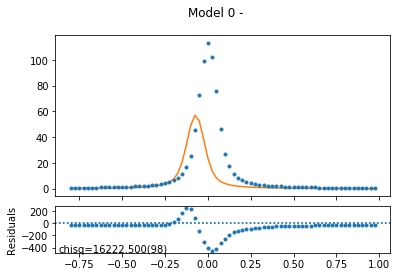

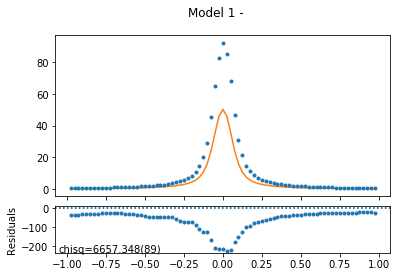

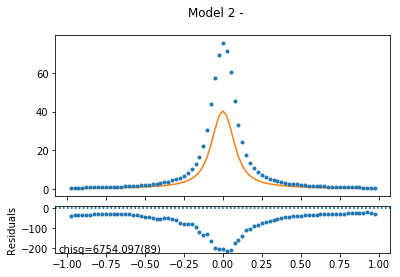

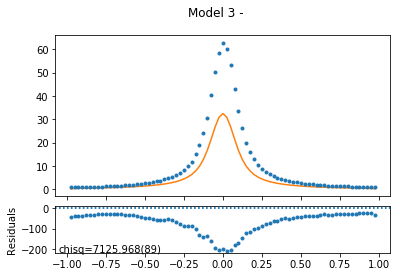

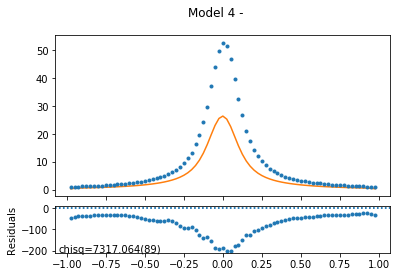

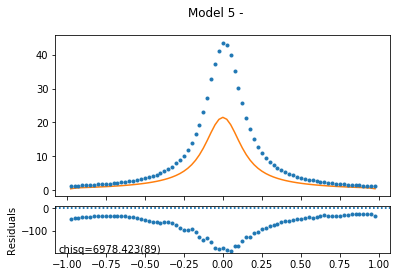

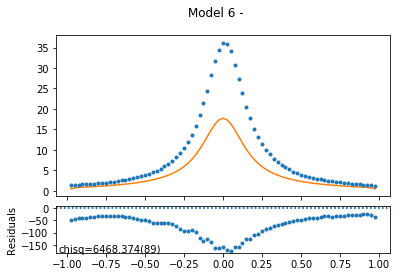

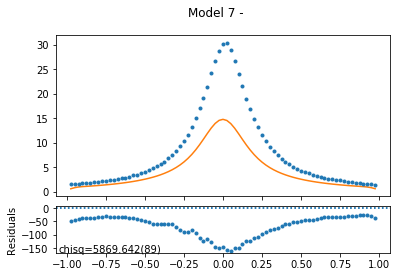

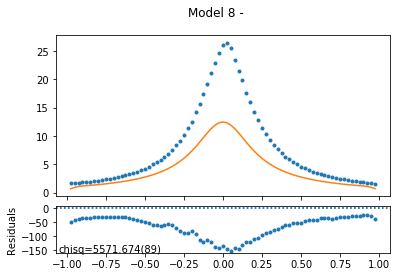

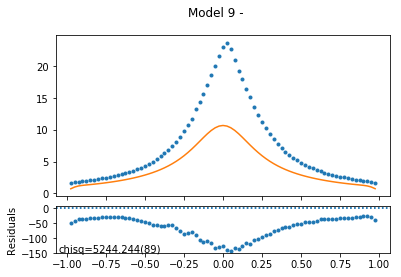

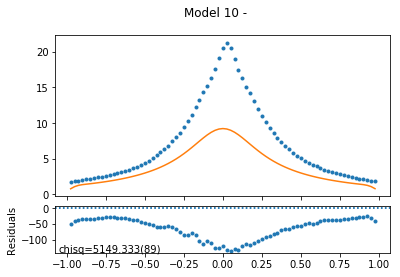

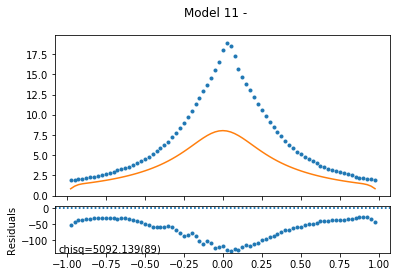

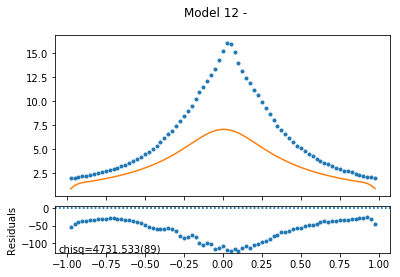

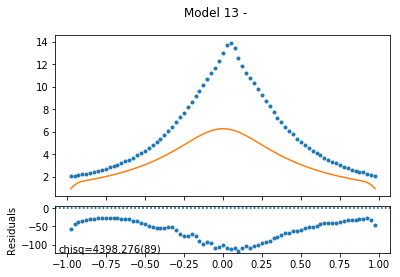

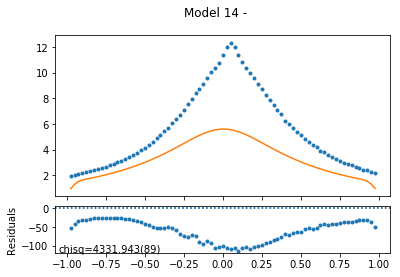

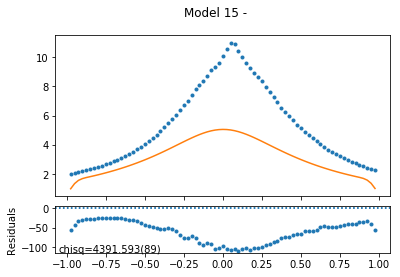

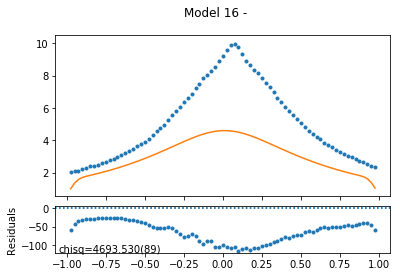

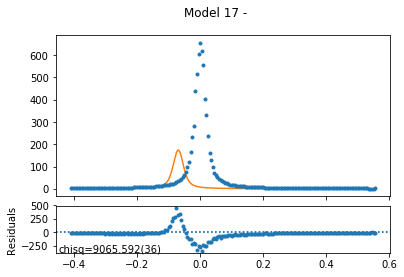

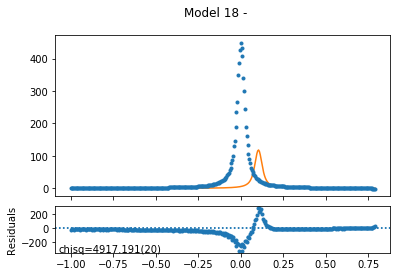

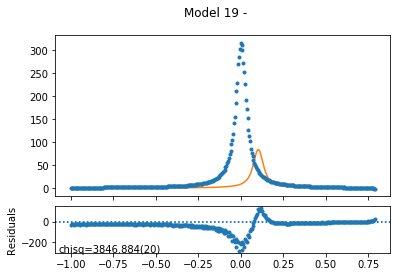

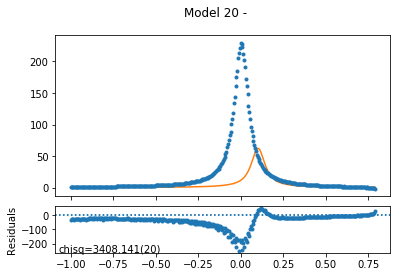

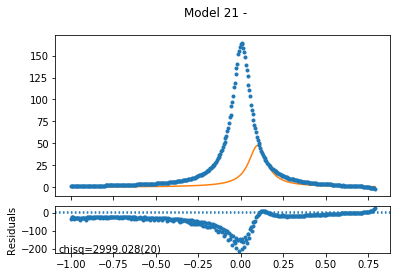

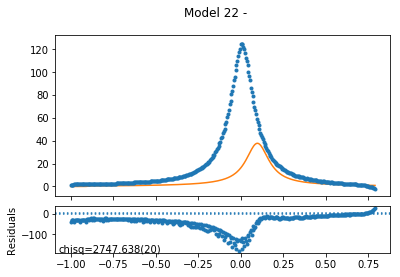

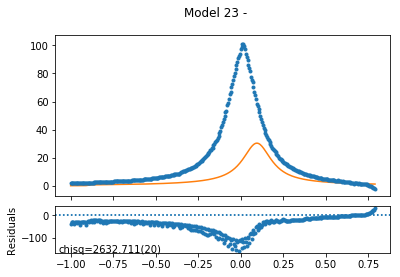

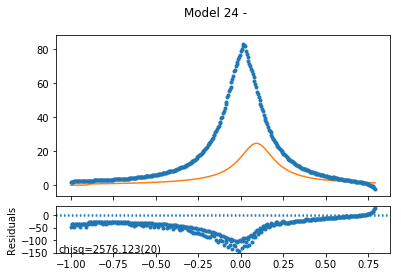

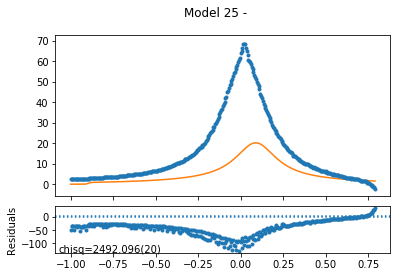

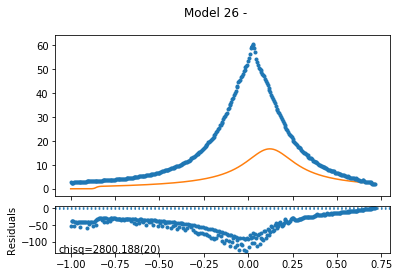

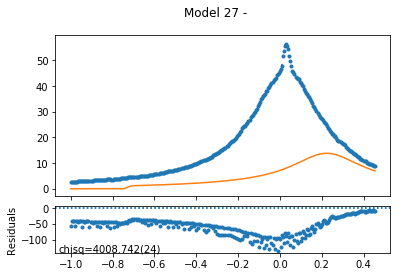

In [7]:
%run -m bumps.cli $model_file --fit=$minimiser --steps=$steps --store=$output_folder

(<a href='#Table of Contents'>Top</a>)<a id='results'></a><h2>Showing the results </h2>

In [8]:
# DISPLAY SOME RESULTS (Bumps output)
par_file = os.path.splitext(model_file)[0] + '.par'
err_file = os.path.splitext(model_file)[0] + '.err'

with open(os.path.join('.', output_folder, par_file), 'r') as fid:
    for line in fid:
        parameter, value = line.split()
        print(parameter, value)
        
with open(os.path.join(os.getcwd(), output_folder, err_file), 'r') as ferr:
    for line in ferr:
        print(line.rsplit('\n')[0])

D 0.129963977981641
DR 0.18751149667532
center 0.00329522999329976
radius 0.900000007461278
resTime 0.473835266748056
scale 9.9474193964665
center -2.14046053128669e-06
scale 10.8732008660842
center -2.99864396167898e-06
scale 10.8852434808419
center 6.65810678098412e-05
scale 10.9116862475626
center -0.0018088447514534
scale 10.9268399712904
center 8.39242279438657e-05
scale 10.9068825622887
center 1.09192009122356e-05
scale 10.8721567838265
center -0.000748138413644127
scale 10.8254331509972
center -0.000295096107334529
scale 10.7970407866023
center 0.000187021088467443
scale 10.7771416721365
center 0.000206149324048472
scale 10.7746852272086
center -0.000634418081839564
scale 10.7723053822449
center 0.0047436203941318
scale 10.7467015140135
center 5.05984624288498e-05
scale 10.718083140597
center 0.00334426041743487
scale 10.7164374124894
center 0.00168749519211332
scale 10.7242596779546
center 0.00995967257482996
scale 10.7483097939119
center 0.000642449557797881
scale 9.4336922151

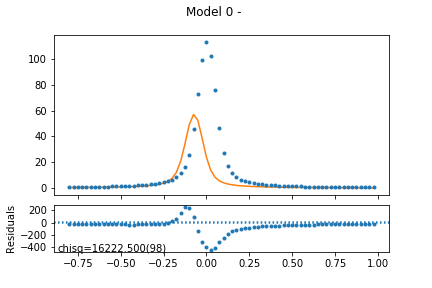

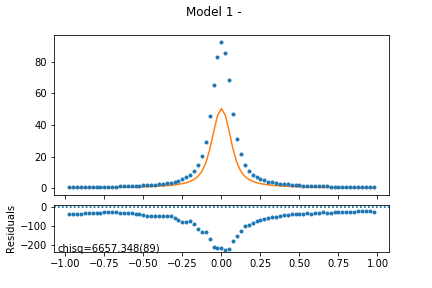

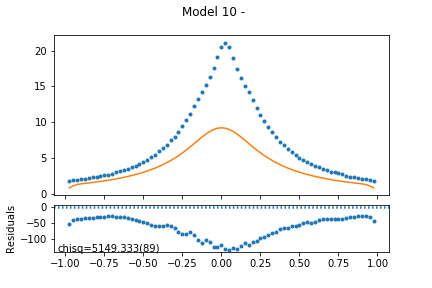

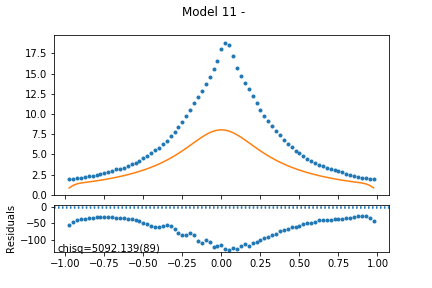

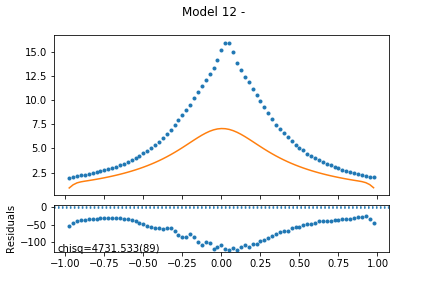

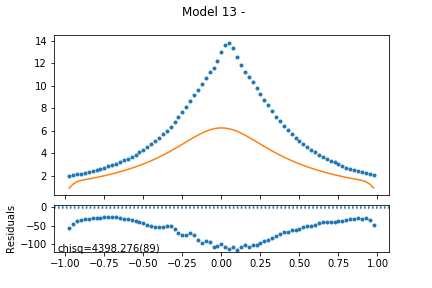

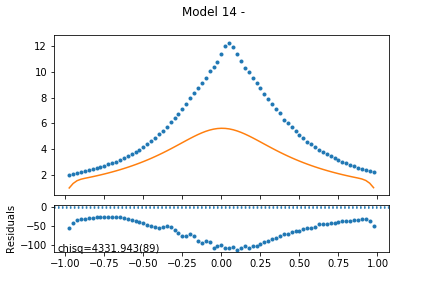

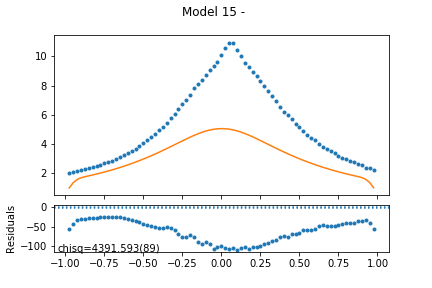

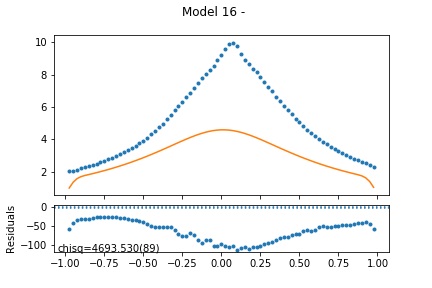

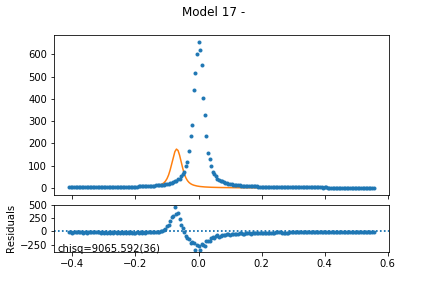

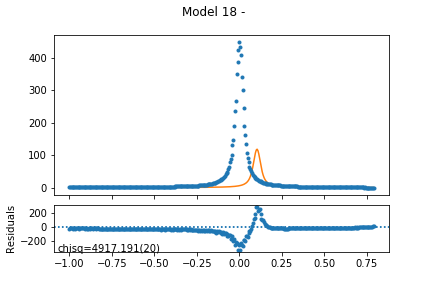

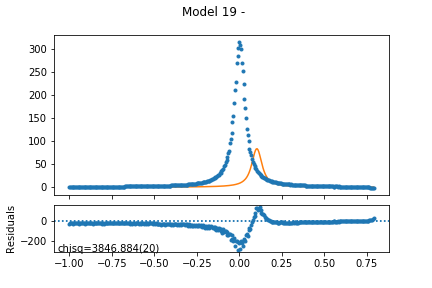

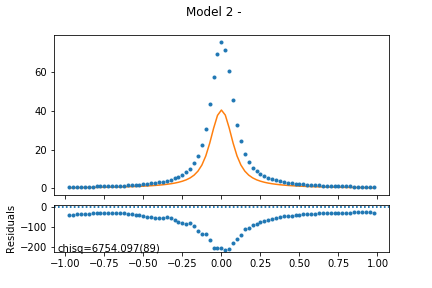

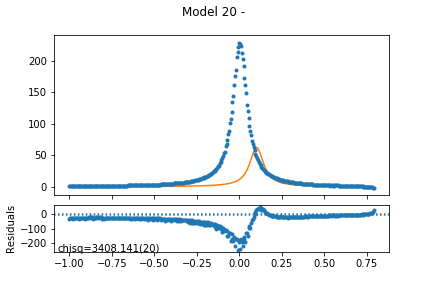

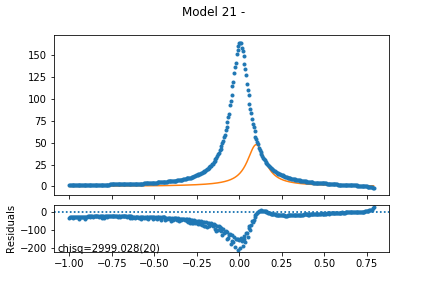

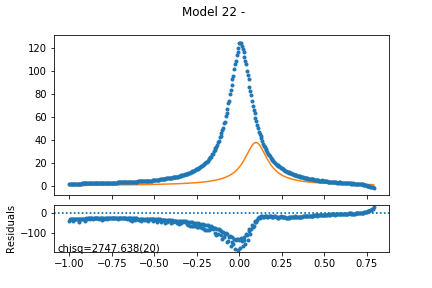

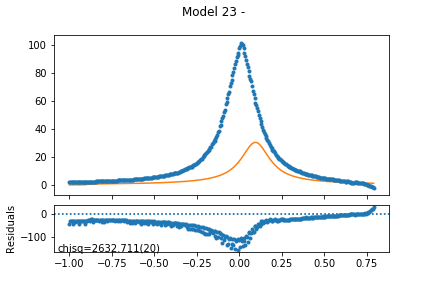

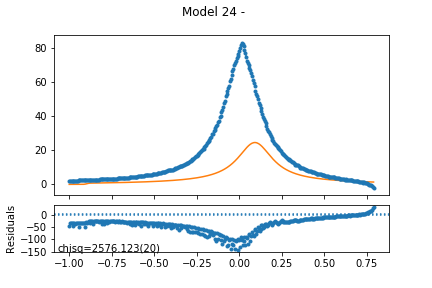

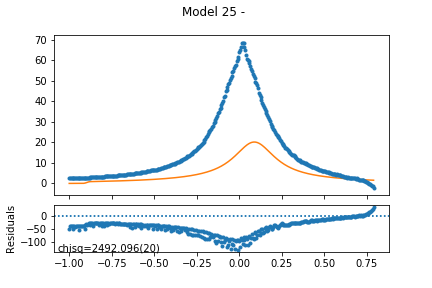

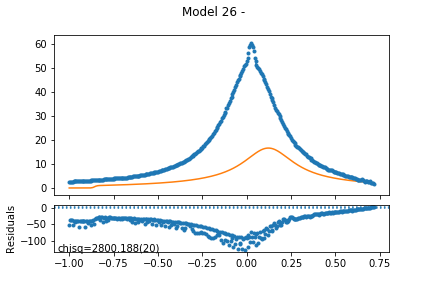

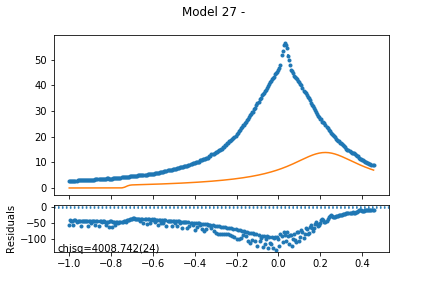

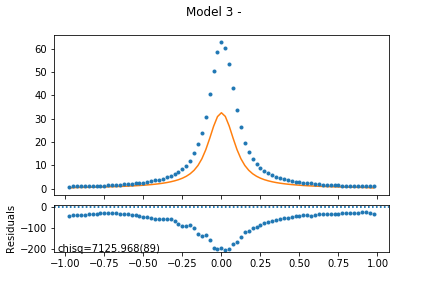

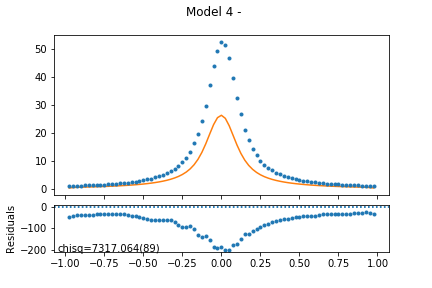

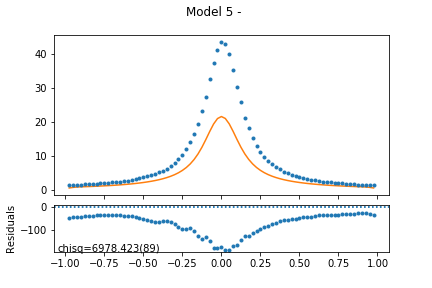

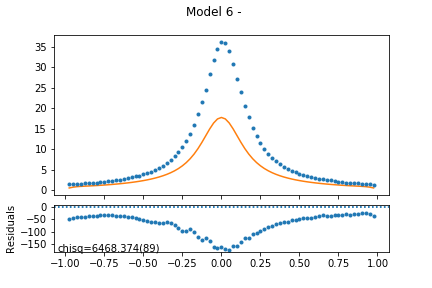

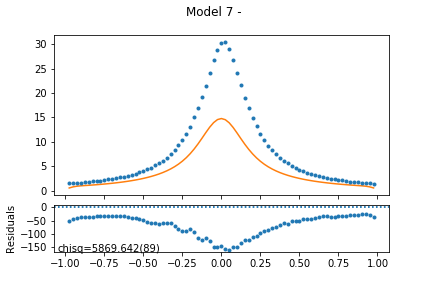

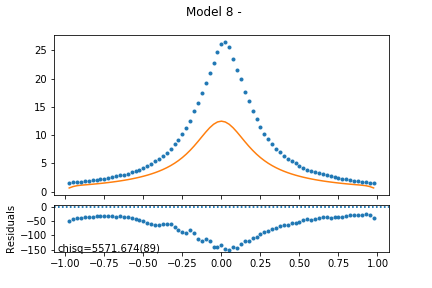

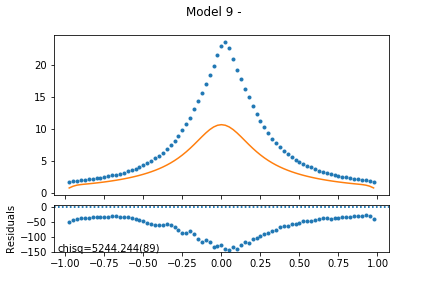

In [9]:
# Plot the fitting results

from IPython.display import display, Image
relative_output_path = os.path.join('.', output_folder)
names = [f for f in os.listdir(relative_output_path) if f.endswith('.png')]

for name in names:
    display(Image(os.path.join(relative_output_path, name)))